In [2]:
try:
    gotoexpect
    import plaidml.keras
    plaidml.keras.install_backend()
    os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
    from keras import backend as K
    # example of training a gan on mnist
    import keras
    from keras.optimizers import Adam
    from keras import Sequential
    from keras import layers
    from keras.layers import Dense
    from keras.layers import Reshape
    from keras.layers import Flatten
    from keras.layers import Conv2D
    from keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from keras.layers import LeakyReLU
    from keras.layers import Dropout
    from keras.models import load_model
    from keras.callbacks import EarlyStopping
    from keras.callbacks import ModelCheckpoint
    #------------------------------
    print("Running on MAC OS")
    
except:
    from tensorflow.keras.optimizers import Adam
    from tensorflow import keras
    from tensorflow.keras import Sequential
    from tensorflow.keras import layers
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Reshape
    from tensorflow.keras.layers import Flatten
    from tensorflow.keras.layers import Conv2D
    from tensorflow.keras.layers import Conv2DTranspose, MaxPooling2D, UpSampling2D, ZeroPadding2D, Cropping2D
    from tensorflow.keras.layers import LeakyReLU
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.models import load_model
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.optimizers import Adam
    print("Running on Server/PC")
    #------------------------------------------


import os
from os.path import exists as file_exists    

# Libraries
import glob
import csv
import json
import math
import joblib
#------------------------------
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
# import visualkeras

# Metric
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler 
#------------------------------

import scipy
import scipy.cluster.hierarchy as sch

# %%
# Creating two lists of ambient and attack datasets
cur_dir= os.getcwd()
dataset = 'syncan'
# dataset = 'road'


ambient_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//ambients//*.csv")
attack_dirs = glob.glob(cur_dir+f"//..//data//{dataset}//generated//attacks//*.csv")

# Creating two lists of file names 
ambient_files = [x.split("/")[-1].split(".")[0][0:-10] for x in ambient_dirs]
attack_files = [x.split("/")[-1].split(".")[0][0:-10] for x in attack_dirs]

print(f"Ambient files are:\n {ambient_files[0:]}, etc.")
print(f"Attack files are:\n {attack_files[0:]}, etc.")

# %%
ambient_files

# %%
# Defining parameters...........

Running on Server/PC
Ambient files are:
 [], etc.
Attack files are:
 [], etc.


[]

In [3]:
def find_attacks(y_list):

    attack_index = []
    attacks = []
    y_1 = 0
    y_2 = 0

    #attacks = []
    for i, y in enumerate (y_list):
        y_2 = y
        if y_1 == 0 and y_2 == 1:
            starting = i
            #print("Starting: ", starting)
        elif y_1 == 1 and y_2 == 0:
            ending = i
            attacks.append([starting, ending, (ending-starting)])
            attack_index += list(range(starting,ending, 1))
            #print(starting, ending, ending-starting)
        y_1 = y_2

#     print("Total attacks", len(attacks))
#     print("Attack positions (starting, ending, ending-starting)\n", attacks[0:2])
    
    return attacks, attack_index


In [4]:
# %%
# Defining functions..............................
#-----------------------------------------------
def sigmoid(x):
    return 1/(1+np.exp(-x))
#-----------------------------------------------
def create_x_sequences(X_values, time_step, window_step, sampling_period):
    X_output = []
    x_indeces = []
    for i in range(100*time_step, len(X_values), window_step):
        X_output.append(X_values[(i - sampling_period*time_step) : i : sampling_period])
        x_indeces.append(i)
    return np.array(x_indeces), np.stack(X_output).reshape(-1, time_step, noOfSignals, 1)


#-----------------------------------------------
def create_y_sequences(y_values, time_step, window_step, sampling_period):
    y_output = []
    for i in range(100*time_step, len(y_values), window_step):
        if y_values[(i - sampling_period*time_step) : i].sum() > 0:
            y_output.append(1)
        else:
            y_output.append(0)
    return np.stack(y_output)

#--------------- Create Folders -------------
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Detectory created!\n{directory}")
        return False
    else:
        return True
#--------------------------------------

#--------------- Create Folders -------------
def get_minmax_scaler(columns):
    df_min_max = pd.read_csv(f"Scalling_Data/min_max_values_{dataset}.csv", index_col=0)[columns]
    scaler = MinMaxScaler()
    scaler.fit(df_min_max.values)
    print("scaler loaded...!")
    return scaler
#--------------------------------------
#--------------------------------------
def calc_loss(x_org, autoencoder):
    x_recon = autoencoder.predict(x_org)
    recon_loss = np.abs(x_org - x_recon)
    return recon_loss #sigmoid(np.mean(np.mean(recon_loss, axis = 1), axis = 1))


In [6]:
if dataset == 'syncan':
    signals_in_cluster = ['Sig_2_of_ID_7',
     'Sig_2_of_ID_1',
     'Sig_1_of_ID_3',
     'Sig_2_of_ID_10',
     'Sig_2_of_ID_6',
     'Sig_1_of_ID_8',
     'Sig_3_of_ID_2',
     'Sig_1_of_ID_5',
     'Sig_1_of_ID_4',
     'Sig_1_of_ID_6',
     'Sig_2_of_ID_5',
     'Sig_3_of_ID_10',
     'Sig_2_of_ID_3',
     'Sig_1_of_ID_2',
     'Sig_1_of_ID_7',
     'Sig_2_of_ID_2',
     'Sig_1_of_ID_1',
     'Sig_4_of_ID_10',
     'Sig_1_of_ID_10',
     'Sig_1_of_ID_9']
    
    

# Selected signals...........
noOfSignals = len(signals_in_cluster)
print("noOfSignals: ", noOfSignals)

signals_in_cluster

noOfSignals:  20


['Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_6',
 'Sig_1_of_ID_8',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_3_of_ID_10',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_2',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9']

In [7]:
signals_in_cluster = ['Sig_1_of_ID_2',
 'Sig_1_of_ID_7',
 'Sig_2_of_ID_3',
 'Sig_1_of_ID_10',
 'Sig_1_of_ID_9',
 'Sig_1_of_ID_1',
 'Sig_4_of_ID_10',
 'Sig_2_of_ID_2',
 'Sig_3_of_ID_10',
 'Sig_1_of_ID_6',
 'Sig_2_of_ID_5',
 'Sig_1_of_ID_4',
 'Sig_1_of_ID_5',
 'Sig_3_of_ID_2',
 'Sig_1_of_ID_8',
 'Sig_2_of_ID_6',
 'Sig_2_of_ID_10',
 'Sig_2_of_ID_7',
 'Sig_2_of_ID_1',
 'Sig_1_of_ID_3']


#-----------------------
time_steps = [50]
window_step = 7
sampling_periods = [500] #, 50]
training_samples = 1
loss_factors = [90]
time_factors = [90]


In [8]:
# # %%
# #-----------------------
# time_steps = [ 25, 50, 75]
# window_step = 17
# sampling_periods = [1, 5, 10, 50] #, 50]
# training_samples = 1
# loss_factors = [90, 95, 99]
# time_factors = [90, 95, 99]

# # loss_factors = [99]
# # time_factors = [90]


# #-----------------------
transfer = True

# %%
#------------------------------
training_files = ambient_files[-3:-1]
training_dirs = ambient_dirs[-3:-1]

# training_files = ambient_files[2] + ambient_files[-1]
# training_dirs = ambient_dirs[2] + ambient_dirs[-1] 


testing_files = ambient_files[:0] + attack_files[:]
testing_dirs = ambient_dirs[:0] + attack_dirs[:]
#-----------------------
# ensure_dir(f"plots//{dataset}//")
# ensure_dir("AE_Models//")
# ensure_dir("Scalling_Data//")
# ensure_dir("plots//Overall//")


In [9]:
# #-----------------------
# file = open(cur_dir+f"//Saved_Data//attacked_signals.json")
# attacked_signals = json.load(file)
# file.close()
# #-----------------------
# attacked_signals

# targeted_signals = []
# for x in attacked_signals.values():
#     targeted_signals+=x
# targeted_signals = list(set(targeted_signals))
# targeted_signals

In [10]:
window_step = 7
sum(sampling_periods)
sum(time_steps)

50

In [11]:
checkpoint_path = f"ae_models//Final_50//Autoencoder_Final_50_1_1_True.h5"
autoencoder = load_model(checkpoint_path)
print(f"{dataset}, Loaded...{checkpoint_path}")

syncan, Loaded...ae_models//Final_50//Autoencoder_Final_50_1_1_True.h5


In [12]:
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 54, 24, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 24, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 54, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 12, 16)        12816     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 27, 12, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 6, 16)        

In [15]:
input_x = np.random.rand(50,20,1,1)

In [16]:
%timeit recon_x = autoencoder.predict(input_x)

35.7 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
# Converting a tf.Keras model to a TensorFlow Lite model.
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp4i_fruvc/assets


INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp4i_fruvc/assets


In [18]:
#save your model in the SavedModel format
export_dir = 'ae_models/converted_model/Final_50//Autoencoder_Final_50_1_1_True'
tf.saved_model.save(autoencoder, export_dir)
# Converting a SavedModel to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ae_models/converted_model/Final_50//Autoencoder_Final_50_1_1_True/assets


INFO:tensorflow:Assets written to: ae_models/converted_model/Final_50//Autoencoder_Final_50_1_1_True/assets


In [20]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()  # Needed before execution!

In [21]:
#get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [22]:
input_details

[{'name': 'serving_default_zero_padding2d_1_input:0',
  'index': 0,
  'shape': array([ 1, 50, 20,  1], dtype=int32),
  'shape_signature': array([-1, 50, 20,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [23]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 43,
  'shape': array([ 1, 50, 20,  1], dtype=int32),
  'shape_signature': array([-1, 50, 20,  1], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [26]:
input_x.shape

(50, 20, 1, 1)

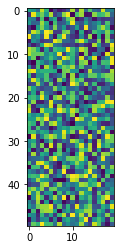

In [27]:
plt.imshow(input_x.reshape(1, 50, 20, 1)[0])

In [30]:
import datetime
# %%timeit
begin_time = datetime.datetime.now()
input_x = np.random.rand(50,20,1)
#Preprocess the image to required size and cast
input_tensor= np.array(input_x.reshape(1, 50, 20, 1), dtype=np.float32)
#set the tensor to point to the input data to be inferred
input_index = input_details[0]["index"]


interpreter.set_tensor(input_index, input_tensor)
#Run the inference
interpreter.invoke()
output_details = interpreter.get_output_details()

pred_x = interpreter.get_tensor(output_details[0]['index'])
end_time = datetime.datetime.now()
time_elapsed =  end_time - begin_time
print(time_elapsed.total_seconds()*1000)

2.1470000000000002


2.1470000000000002
Prediction results shape: (1, 50, 20, 1)


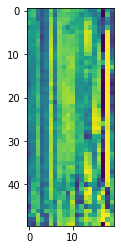

In [31]:
print(time_elapsed.total_seconds()*1000)
print("Prediction results shape:", pred_x.shape)
plt.imshow(pred_x[0])

In [71]:
import tensorflow as tf

# Create a model using high-level tf.keras.* APIs
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1]),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model.compile(optimizer='sgd', loss='mean_squared_error') # compile the model
model.fit(x=[-1, 0, 1], y=[-3, -1, 1], epochs=5) # train the model

# # (to generate a SavedModel) 
# # tf.saved_model.save(model, "saved_model_keras_dir")
# tf.keras.models.save_model(model, "saved_ae_model")

# model = tf.keras.models.load_model("saved_ae_model")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Epoch 1/5
1/1 [==============================] - 0s 223ms/step - loss: 3.3036
Epoch 2/5
1/1 [==============================] - 0s 2ms/step - loss: 3.1047
Epoch 3/5
1/1 [==============================] - 0s 2ms/step - loss: 2.9055
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - loss: 2.7156
Epoch 5/5
1/1 [==============================] - 0s 2ms/step - loss: 2.5329


INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp8v9bhyf7/assets


INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp8v9bhyf7/assets


In [72]:
import tensorflow as tf

# Create a model using high-level tf.keras.* APIs
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1]),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1)
])
model.compile(optimizer='sgd', loss='mean_squared_error') # compile the model
model.fit(x=[-1, 0, 1], y=[-3, -1, 1], epochs=5) # train the model
# (to generate a SavedModel) tf.saved_model.save(model, "saved_model_keras_dir")

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Epoch 1/5
1/1 [==============================] - 0s 219ms/step - loss: 4.4226
Epoch 2/5
1/1 [==============================] - 0s 2ms/step - loss: 4.2149
Epoch 3/5
1/1 [==============================] - 0s 3ms/step - loss: 4.0128
Epoch 4/5
1/1 [==============================] - 0s 2ms/step - loss: 3.8274
Epoch 5/5
1/1 [==============================] - 0s 3ms/step - loss: 3.6560


INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp9pfp95kk/assets


INFO:tensorflow:Assets written to: /var/folders/5y/c3t599md62l1vpqw2_zf_7qh0000gn/T/tmp9pfp95kk/assets


In [14]:
# # th_loss_df = pd.read_csv(f"Saved_Data//thresholds_loss_{dataset}_{sum(time_steps)}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)   
# # th_time_df = pd.read_csv(f"Saved_Data//thresholds_time_{dataset}_{sum(time_steps)}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)
# # print("th_time_df loaded....")
# th_loss_df = pd.read_csv(f"Saved_Data//thresholds_loss_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)   
# th_time_df = pd.read_csv(f"Saved_Data//thresholds_time_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)
# print("th_time_df loaded....")

In [15]:
try:
#     th_time_df = pd.read_csv(f"Saved_Data//thresholds_time_{dataset}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)
#     th_loss_df = pd.read_csv(f"Saved_Data//thresholds_loss_{dataset}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)
#     print("th_time_df loaded....")
    th_loss_df = pd.read_csv(f"Saved_Data//thresholds_loss_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)   
    th_time_df = pd.read_csv(f"Saved_Data//thresholds_time_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index_col=0)
    print("th_time_df loaded....")
    
#     regenerate

except :
    print("No ths found!!!!!!")
    th_time_df = pd.DataFrame([])
    th_loss_df = pd.DataFrame([])

    for file_index, (file_name, file_dir) in enumerate(zip(ambient_files[:], ambient_dirs[:])):

        print("Loading dataset: ",file_name)
        
        if file_name == 'ambient_highway_street_driving_long':
            continue
            
#         if file_name != 'ambient_dyno_drive_basic_short':
#             continue
            

        # Checking if the signalwise data already exists
        sig_df = pd.read_csv(file_dir, index_col = 0) 
        print(f"{file_name} onboarded!")

        # Defining the number of signals..............................
        num_of_train_samples = int(sig_df.shape[0]*training_samples)
        sig_df = sig_df.iloc[0:num_of_train_samples].copy()        
        y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()
        sig_df = sig_df[signals_in_cluster].copy()


        if dataset == 'road':
            # Forward filling algorithm........
            print("Forward filling...")
            sig_df = sig_df.ffill().copy()
            sig_df = sig_df.bfill().dropna()   
            #------------------------------------
        else:
            print("No treatment needed for SynCAN!")
        
        X_train = sig_df.values.copy()
        #--------------------------------
        print("X_train.shape", X_train.shape)

        scaler_train = get_minmax_scaler(signals_in_cluster)
        X_train = scaler_train.transform(X_train).copy()
        print("Done data treatment..")
            


        for time_step_indx, time_step in enumerate(time_steps):
            for sampling_period_indx, sampling_period in enumerate(sampling_periods):

                #find losses.............................
                print("Creating sequences....")
                x_train_index, x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period)
                y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

                print("Training input shape: ", x_train_seq.shape)

                #.......................... Training the model ....................
                print("------------- Starting the training process----------------")
#                 checkpoint_path = f"AE_Models//autoendoer_canshield_{dataset}_{time_step}_{window_step}_{sampling_period}_{training_samples}.h5"
#                 checkpoint_path = f"AE_Models//nov4//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"

                #checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"

                try:
                    checkpoint_path = f"AE_Models//{dataset}_old//Autoencoder_Final_{time_step}_1_{sampling_period}_True.h5"
                    autoencoder = load_model(checkpoint_path)
                    print(f"{dataset}, Loaded...{checkpoint_path}")
                except:
                    checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"
                    autoencoder = load_model(checkpoint_path)
                    print(f"{dataset}, Loaded...{checkpoint_path}")

                print("------------------------ Done ------------------------")

                print("Predicting..losses...")
                #-------------  Training ------------------
                y_train_prob_org = calc_loss(x_train_seq[0::], autoencoder)[:,:,:,0]
                y_train_prob = y_train_prob_org.reshape(-1,noOfSignals)
                #-------------------------------------------

                
                print(".....loss_factors.....")
                for loss_factor in loss_factors:
                    print("Loss:", loss_factor)
                    th_values = {}
                    for Signal, y_train_prob_signal in enumerate(y_train_prob.T):
                        th = np.percentile(y_train_prob_signal, loss_factor)
                        th_values['file'] = file_name
                        th_values['sampling_period'] = sampling_period
                        th_values['time_step'] = time_step
                        th_values['loss_factor'] = loss_factor
                        th_values['th'] = th 
                        th_values['Signal'] = Signal
                        # ths[f"{file_name}_{time_step}_{sampling_period}_{factor}_{Signal}"] = th
                        th_loss_df = pd.concat([th_loss_df, pd.DataFrame(th_values, index = [0])], ignore_index= True)
                        #-----------
                    #-------------------------------------------------------------------------------------------
                    ths_loss = th_loss_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'Signal']).mean()

                    # Starting with time steps violations.............
                    ths_image = []
                    for signal in range(noOfSignals):
                        ths_image.append(ths_loss.loc[(time_step, sampling_period, loss_factor, signal)]['th'])
                    ths_image = np.array(ths_image)


                    y_train_prob_org_bin = (y_train_prob_org> ths_image).astype(int).copy()
                    y_train_prob_org_bin_count = np.sum(y_train_prob_org_bin, 1)

                    #-------------------------------------------

                    print(".....time_factors.....")
                    for time_factor in time_factors:
                        print(f".....{time_factor}.....")
                        th_values = {}
                        for Signal, y_train_prob_org_bin_count_each in enumerate(y_train_prob_org_bin_count.T):
                            th = np.percentile(y_train_prob_org_bin_count_each, time_factor)

                            th_values['file'] = file_name

                            th_values['time_step'] = time_step
                            th_values['sampling_period'] = sampling_period
                            th_values['loss_factor'] = loss_factor
                            th_values['time_factor'] = time_factor
                            th_values['th'] = th 
                            th_values['Signal'] = Signal
    #                         ths[f"{file_name}_{time_step}_{sampling_period}_{factor}_{Signal}"] = th
                            th_time_df = pd.concat([th_time_df, pd.DataFrame(th_values, index = [0])], ignore_index= True)
                            #-----------
    th_loss_df.to_csv(f"Saved_Data//thresholds_loss_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index = True, header = True)
    th_time_df.to_csv(f"Saved_Data//thresholds_time_{dataset}_{window_step}_{sum(time_steps)}_{sum(sampling_periods)}.csv", index = True, header = True)
    
ths_time = th_time_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'time_factor', 'Signal']).mean()
ths_loss = th_loss_df.groupby(['time_step', 'sampling_period', 'loss_factor', 'Signal']).mean()
ths_time

th_time_df loaded....


th
time_step sampling_period loss_factor time_factor Signal      
20        1               90          90          0       9.25
                                                  1       8.00
                                                  2       9.25
                                                  3       6.00
                                                  4       6.00
...                                                        ...
100       50              99          99          15      3.75
                                                  16      6.00
                                                  17      5.00
                                                  18      4.00
                                                  19      4.00

[2700 rows x 1 columns]

In [16]:
#-----------------------
time_steps = [50]
window_step = 1
sampling_periods = [1, 5, 10, 20, 50]
training_samples = 1
loss_factors = [90, 95, 99]
time_factors = [90, 95, 99]

In [17]:
## Calculating losses....or violations..............

In [18]:
window_step = 1
training_samples = 0.5

In [19]:
# %%

#------- Initilizing models/loading model-------------
#-------- Transfering the model-------------------------------
    # Visualizing the attacks...............................    
y_true_dict = {}
y_loss_dict = {}
y_time_dict = {}
y_sig_dict = {}
x_index_seq = {}


#Loading datasets..................................
# reading each dataset in a df file


for file_index, (file_name, file_dir) in enumerate(zip(testing_files, testing_dirs)):

    if file_name.split('_')[0] == 'accelerator':
        print("Acceleration Attack Skipping....")
        continue
    
    print("Loading dataset: ",file_name)
    # Checking if the signalwise data already exists
    sig_df = pd.read_csv(file_dir, index_col = 0) 
    print(f"{file_name} onboarded!")

    # Defining the number of signals..............................
    num_of_train_samples = int(sig_df.shape[0]*training_samples)
    y_train = sig_df['Label'].iloc[num_of_train_samples:].copy()
    sig_df = sig_df.iloc[num_of_train_samples:].copy()        
    sig_df = sig_df[signals_in_cluster].copy()


    if dataset == 'road':
        # Forward filling algorithm........
        print("Forward filling...")
        sig_df = sig_df.ffill().copy()
        sig_df = sig_df.bfill().dropna()   
        #------------------------------------
    else:
        print("No treatment needed for SynCAN!")

    X_train = sig_df.values.copy()
    #--------------------------------
    print("X_train.shape", X_train.shape)

    scaler_train = get_minmax_scaler(signals_in_cluster)
    X_train = scaler_train.transform(X_train).copy()
    print("Done data treatment..")
  

#     att_signals = targeted_signals.copy()
#     total_vis_indeces = X_train.shape[0] if dataset == 'road' else int(X_train.shape[0]/1)
#     index_end = index_init + total_vis_indeces
    
#     xrange = np.array(range(index_init, index_end))

    for time_step_indx, time_step in enumerate(time_steps):
        for sampling_period_indx, sampling_period in enumerate(sampling_periods):
            # Creating sequences...........................................
            print("Creating sequences....")
            x_train_index, x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period)
            y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

            print(f" time_step : {time_step}, sampling_period: {sampling_period}, y_train_seq.shape: ", x_train_seq.shape)
            #-----------------------------------------------------------
            #.......................... Training the model ....................
            print("------------- Starting the training process----------------")
           


            try:
                checkpoint_path = f"AE_Models//{dataset}_old//Autoencoder_Final_{time_step}_1_{sampling_period}_True.h5"
                autoencoder = load_model(checkpoint_path)
                print(f"{dataset}, Loaded...{checkpoint_path}")
            except:
                checkpoint_path = f"AE_Models//{dataset}//autoendoer_canshield_{dataset}_{time_step}_1_{sampling_period}_1.h5"
                autoencoder = load_model(checkpoint_path)
                print(f"{dataset}, Loaded...{checkpoint_path}")

            print("------------------------ Done ------------------------")


            # Predicting
            #-------------  Training ------------------
            y_train_prob_org = calc_loss(x_train_seq[0::1], autoencoder)[:,:,:,0]   
            y_train_prob = y_train_prob_org.reshape(-1,noOfSignals)
            #-------------------------------------------
            y_train_prob_org_loss = np.mean(np.mean(y_train_prob_org, 2),1).copy()

            

            
                
            # Starting with time steps violations.............

            for loss_factor in loss_factors:
                ths_image = []
                for signal in range(noOfSignals):
                    ths_image.append(ths_loss.loc[(time_step, sampling_period, loss_factor, signal)]['th'])
                ths_image = np.array(ths_image)

                y_train_prob_org_bin = (y_train_prob_org> ths_image).astype(int).copy()

                y_train_prob_org_bin_count_score = np.sum(np.sum(y_train_prob_org_bin, 2),1)
                y_train_prob_org_bin_count_score = (y_train_prob_org_bin_count_score/(noOfSignals*time_step)).copy()
                #-----------------------------------------------------------
                y_train_prob_org_bin_count = np.sum(y_train_prob_org_bin,1).copy()

                for time_factor in time_factors:
                    
                    ths_image = []
                    for signal in range(noOfSignals):
                        ths_image.append(ths_time.loc[(time_step, sampling_period, loss_factor, time_factor, signal)]['th'])
                    ths_image = np.array(ths_image)

                    y_train_prob_org_sig_count = (y_train_prob_org_bin_count> ths_image).astype(int).copy()
                    y_train_prob_org_sig_count = np.sum(y_train_prob_org_sig_count, 1)/noOfSignals

                    # Adding values...........
                    if dataset == 'syncan':
                        key = f"{file_name[5:]}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                    else:
                        key = f"{file_name[:-20]}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                        
                        
                    try:
                        
                        y_true_dict[key] += list(y_train_seq)
                        y_loss_dict[key] += list(y_train_prob_org_loss)
                        y_time_dict[key] += list(y_train_prob_org_bin_count_score)
                        y_sig_dict[key] += list(y_train_prob_org_sig_count)
                        x_index_seq[key] += list(last_index + x_train_index)

                    except:
                        
                        y_true_dict[key] = list(y_train_seq)
                        y_loss_dict[key] = list(y_train_prob_org_loss)
                        y_time_dict[key] = list(y_train_prob_org_bin_count_score)
                        y_sig_dict[key]  = list(y_train_prob_org_sig_count)
                        x_index_seq[key] = list(x_train_index)
                    
                    last_index = x_train_index[-1]




Loading dataset:  test_plateau


/Users/hshahriar/anaconda3/envs/tensorgpu/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


test_plateau onboarded!
No treatment needed for SynCAN!
X_train.shape (1075026, 20)
scaler loaded...!
Done data treatment..
Creating sequences....


KeyboardInterrupt: 

In [ ]:
# training_samples

In [ ]:
# training_samples = 0.10

In [20]:
try:
    load
    y_true_dict
except:
    y_true_dict = {}
    y_loss_dict = {}
#     y_time_dict = {}
    y_sig_dict = {}
#     x_index_seq = {}

y_dict_final = {
    'y_true_dict': y_true_dict,
    'y_loss_dict': y_loss_dict,
#     'y_time_dict': y_time_dict,
    'y_sig_dict' : y_sig_dict}
#     'x_index_seq': x_index_seq}

# Loading the dataset.......




In [21]:
import pickle
pred_dir = f'prediction_data//{dataset}_{int(training_samples*100)}_1//'
for y_name, y_dict in y_dict_final.items():
    print(y_name)
    #Creating directory
    dir_folder = pred_dir+y_name+"//"   
    for each_file in glob.glob(f"{dir_folder}//*.txt"):
        key = each_file.split("/")[-1].split(".")[0]
        with open(each_file, "rb") as fp:   # Unpickling
            y_dict[key] = pickle.load(fp)

y_true_dict
y_loss_dict
y_sig_dict


In [22]:
len(y_dict[key])

1070026

In [23]:
import pickle
pred_dir = f'prediction_data//{dataset}_{int(training_samples*100)}_2//'
for y_name, y_dict in y_dict_final.items():
    print(y_name)
    #Creating directory
    dir_folder = pred_dir+y_name+"//"   
    for each_file in glob.glob(f"{dir_folder}//*.txt"):
        key = each_file.split("/")[-1].split(".")[0]
        with open(each_file, "rb") as fp:   # Unpickling
            y_dict[key] += pickle.load(fp)

y_true_dict
y_loss_dict
y_sig_dict


In [24]:
len(y_dict[key])

2140052

In [ ]:
# # Saving the dataset.......
# import pickle
# pred_dir = f'prediction_data//{dataset}_{int(training_samples*100)}_Last//'
# for y_name, y_dict in y_dict_final.items():
#     print(y_name)
#     #Creating directory
#     dir_folder = pred_dir+y_name+"//"
#     ensure_dir(dir_folder)
#     #Saving each and every list...
#     for key, value in y_dict.items():
#         with open(f"{dir_folder}//{key}.txt", "wb") as fp:   #Pickling
#             pickle.dump(value, fp)

In [ ]:
# # Loading the dataset.......

# import pickle
# pred_dir = f'prediction_data//{dataset}_{int(training_samples*100)}//'
# for y_name, y_dict in y_dict_final.items():
#     print(y_name)
#     #Creating directory
#     dir_folder = pred_dir+y_name+"//"   
#     for each_file in glob.glob(f"{dir_folder}//*.txt"):
#         key = each_file.split("/")[-1].split(".")[0]
#         with open(each_file, "rb") as fp:   # Unpickling
#             y_dict[key] = pickle.load(fp)
#     break

In [ ]:
# (np.array(y_true_dict_temp['playback_50_1_99_90']) - np.array(y_true_dict['playback_50_1_99_90'])).sum()

In [25]:
y_sig_dict.keys()

dict_keys(['plateau_50_1_95_99', 'plateau_50_5_95_99', 'plateau_50_10_95_99', 'suppress_50_1_95_99', 'suppress_50_5_95_99', 'suppress_50_10_95_99', 'continuous_50_1_95_99', 'continuous_50_5_95_99', 'continuous_50_10_95_99', 'flooding_50_1_95_99', 'flooding_50_5_95_99', 'flooding_50_10_95_99', 'playback_50_1_95_99', 'playback_50_5_95_99', 'playback_50_10_95_99', 'plateau_50_1_90_90', 'plateau_50_1_90_95', 'plateau_50_1_90_99', 'plateau_50_1_95_90', 'plateau_50_1_95_95', 'plateau_50_1_99_90', 'plateau_50_1_99_95', 'plateau_50_1_99_99', 'plateau_50_5_90_90', 'plateau_50_5_90_95', 'plateau_50_5_90_99', 'plateau_50_5_95_90', 'plateau_50_5_95_95', 'plateau_50_5_99_90', 'plateau_50_5_99_95', 'plateau_50_5_99_99', 'plateau_50_10_90_90', 'plateau_50_10_90_95', 'plateau_50_10_90_99', 'plateau_50_10_95_90', 'plateau_50_10_95_95', 'plateau_50_10_99_90', 'plateau_50_10_99_95', 'plateau_50_10_99_99', 'plateau_50_20_90_90', 'plateau_50_20_90_95', 'plateau_50_20_90_99', 'plateau_50_20_95_90', 'plateau

In [26]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [27]:
testing_files

['test_plateau',
 'test_suppress',
 'test_continuous',
 'test_flooding',
 'test_playback']

In [28]:
file_details= {}

if dataset == 'road':
    file_details = {'max_speedometer': 'Max Speedometer',
    'reverse_light_on': 'Reverse light on',
    'reverse_light_off': 'Reverse light off',
    'correlated_signal': 'Correlated Signals',
    'max_engine_coolant_te': 'Max coolant temp'}
else:
    for file in testing_files:
        file_details[file] = file[5:].capitalize()

file_details

{'test_plateau': 'Plateau',
 'test_suppress': 'Suppress',
 'test_continuous': 'Continuous',
 'test_flooding': 'Flooding',
 'test_playback': 'Playback'}

In [29]:
file_indeces = {}
i = 0
#Loading datasets..................................
for file_index, file_name in enumerate(testing_files):
 # Adding values...........
    file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
    if file_name not in list(file_indeces.keys()):
        file_indeces[file_name] = i
        i+=1
file_indeces

{'plateau': 0, 'suppress': 1, 'continuous': 2, 'flooding': 3, 'playback': 4}

In [30]:
if dataset == 'syncan':
    attack_names = ['flooding', 'suppress', 'plateau', 'continuous', 'playback', 'Average']
else:
    attack_names = list(file_indeces.keys()) + ['Average']
attack_names

['flooding', 'suppress', 'plateau', 'continuous', 'playback', 'Average']

In [31]:
# file_indeces = {}
# i = 0
# #Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
#  # Adding values...........
#     file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
#     if file_details[file_name] not in list(file_indeces.keys()):
#         file_indeces[file_details[file_name]] = i
#         i+=1
# file_indeces

In [32]:
import itertools

In [33]:
file_indeces.items()

dict_items([('plateau', 0), ('suppress', 1), ('continuous', 2), ('flooding', 3), ('playback', 4)])

In [34]:
roc_data = {}
roc_curves = {}

#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for file_name, file_index in file_indeces.items():
 
    print(file_name)

    best_auc = 0
    for time_step_indx, time_step in enumerate(time_steps):
        print(f"time_step: {time_step}")
        
        for total_aes in range(1, len(sampling_periods)+1):
            for sampling_periods_temp in itertools.combinations(sampling_periods, total_aes):
                
                print(f"Considering: {sampling_periods_temp}")

                for loss_factor_indx, loss_factor in enumerate(loss_factors):
                    for time_factor_indx, time_factor in enumerate(time_factors):
                        key = f"{file_name}_{time_step}_{sampling_periods_temp}_{loss_factor}_{time_factor}"
                        
                        print(key)
                        
                        try: del y_pred_avg, y_test_avg 
                        except: pass 
                        
                        for sampling_period_indx, sampling_period in enumerate(sampling_periods_temp):
                            #--------------------------------------------------------------------------
                            key_org = f"{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                            y_pred = y_loss_dict[key_org].copy() 
                            y_test = y_true_dict[key_org].copy()
                            print(len(y_pred))
                            #--------------------------------------------------------------------------
                            try:
                                y_pred_avg += np.array(y_pred)
                                y_test_avg += np.array(y_test)

                            except:
                                y_pred_avg = np.array(y_pred)
                                y_test_avg = np.array(y_test)
                                print("Except")
                            #--------------------------------------------------------------------------
                        y_pred_avg =y_pred_avg/len(sampling_periods_temp)
                        y_test_avg =y_test_avg/len(sampling_periods_temp)
                        y_test_avg = (y_test_avg>=0.5).astype(int)
        
        
                        fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
                        roc_auc = auc(fpr, tpr)

                        roc_data[key] = [file_name, f"{total_aes}_{sampling_period_indx}", time_step, sampling_periods_temp, window_step, loss_factor, time_factor, round(roc_auc, 5)]
                        roc_curves[key] = [fpr, tpr, _]
                            
                           

                        
#                 sbest_key = best_key

#                 y_pred_avg =y_pred_avg/len(sampling_periods)
#                 y_test_avg =y_test_avg/len(sampling_periods)
#                 y_test_avg = (y_test_avg>0.5).astype(int)

#                 fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
#                 roc_auc = auc(fpr, tpr)
#                 ax.plot(fpr, tpr, label=f"Avg : {round(roc_auc,2)}")
#                 if best_auc < roc_auc:
#                     best_auc = roc_auc
#                     best_key = f"Combined"
#             ax.set_title(f"Attack: {file_name}") #: AUC: {round(best_auc,2)} \n {best_key}")
#             ax.legend(title = "AUC", loc = 'center right')
#             ax.set_xlabel("False Positive")
#             ax.set_ylabel("True Positive")
#         plt.tight_layout()
#         plt.savefig(f"plots//Overall//ROC_Loss_{dataset}.jpg", dpi = 350)
# plt.show()  

plateau
time_step: 50
Considering: (1,)
plateau_50_(1,)_90_90
2140052
Except
plateau_50_(1,)_90_95
2140052
Except
plateau_50_(1,)_90_99
2140052
Except
plateau_50_(1,)_95_90
2140052
Except
plateau_50_(1,)_95_95
2140052
Except
plateau_50_(1,)_95_99
2140052
Except
plateau_50_(1,)_99_90
2140052
Except
plateau_50_(1,)_99_95
2140052
Except
plateau_50_(1,)_99_99
2140052
Except
Considering: (5,)
plateau_50_(5,)_90_90
2140052
Except
plateau_50_(5,)_90_95
2140052
Except
plateau_50_(5,)_90_99
2140052
Except
plateau_50_(5,)_95_90
2140052
Except
plateau_50_(5,)_95_95
2140052
Except
plateau_50_(5,)_95_99
2140052
Except
plateau_50_(5,)_99_90
2140052
Except
plateau_50_(5,)_99_95
2140052
Except
plateau_50_(5,)_99_99
2140052
Except
Considering: (10,)
plateau_50_(10,)_90_90
2140052
Except
plateau_50_(10,)_90_95
2140052
Except
plateau_50_(10,)_90_99
2140052
Except
plateau_50_(10,)_95_90
2140052
Except
plateau_50_(10,)_95_95
2140052
Except
plateau_50_(10,)_95_99
2140052
Except
plateau_50_(10,)_99_90
214005

Except
2140052
2140052
plateau_50_(1, 10, 20)_95_90
2140052
Except
2140052
2140052
plateau_50_(1, 10, 20)_95_95
2140052
Except
2140052
2140052
plateau_50_(1, 10, 20)_95_99
2140052
Except
2140052
2140052
plateau_50_(1, 10, 20)_99_90
2140052
Except
2140052
2140052
plateau_50_(1, 10, 20)_99_95
2140052
Except
2140052
2140052
plateau_50_(1, 10, 20)_99_99
2140052
Except
2140052
2140052
Considering: (1, 10, 50)
plateau_50_(1, 10, 50)_90_90
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_90_95
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_90_99
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_95_90
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_95_95
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_95_99
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_99_90
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_99_95
2140052
Except
2140052
2140052
plateau_50_(1, 10, 50)_99_99
2140052
Except
2140052
2140052
Considering: (1, 20, 50)
plateau_50_(1, 20, 50)_90_9

Except
suppress_50_(1,)_99_95
2102647
Except
suppress_50_(1,)_99_99
2102647
Except
Considering: (5,)
suppress_50_(5,)_90_90
2102647
Except
suppress_50_(5,)_90_95
2102647
Except
suppress_50_(5,)_90_99
2102647
Except
suppress_50_(5,)_95_90
2102647
Except
suppress_50_(5,)_95_95
2102647
Except
suppress_50_(5,)_95_99
2102647
Except
suppress_50_(5,)_99_90
2102647
Except
suppress_50_(5,)_99_95
2102647
Except
suppress_50_(5,)_99_99
2102647
Except
Considering: (10,)
suppress_50_(10,)_90_90
2102647
Except
suppress_50_(10,)_90_95
2102647
Except
suppress_50_(10,)_90_99
2102647
Except
suppress_50_(10,)_95_90
2102647
Except
suppress_50_(10,)_95_95
2102647
Except
suppress_50_(10,)_95_99
2102647
Except
suppress_50_(10,)_99_90
2102647
Except
suppress_50_(10,)_99_95
2102647
Except
suppress_50_(10,)_99_99
2102647
Except
Considering: (20,)
suppress_50_(20,)_90_90
2102647
Except
suppress_50_(20,)_90_95
2102647
Except
suppress_50_(20,)_90_99
2102647
Except
suppress_50_(20,)_95_90
2102647
Except
suppress_50_

suppress_50_(1, 10, 20)_95_99
2102647
Except
2102647
2102647
suppress_50_(1, 10, 20)_99_90
2102647
Except
2102647
2102647
suppress_50_(1, 10, 20)_99_95
2102647
Except
2102647
2102647
suppress_50_(1, 10, 20)_99_99
2102647
Except
2102647
2102647
Considering: (1, 10, 50)
suppress_50_(1, 10, 50)_90_90
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_90_95
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_90_99
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_95_90
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_95_95
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_95_99
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_99_90
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_99_95
2102647
Except
2102647
2102647
suppress_50_(1, 10, 50)_99_99
2102647
Except
2102647
2102647
Considering: (1, 20, 50)
suppress_50_(1, 20, 50)_90_90
2102647
Except
2102647
2102647
suppress_50_(1, 20, 50)_90_95
2102647
Except
2102647
2102647
suppress_50_(1, 20, 50)_90_99
21026

Except
continuous_50_(1,)_99_95
2140052
Except
continuous_50_(1,)_99_99
2140052
Except
Considering: (5,)
continuous_50_(5,)_90_90
2140052
Except
continuous_50_(5,)_90_95
2140052
Except
continuous_50_(5,)_90_99
2140052
Except
continuous_50_(5,)_95_90
2140052
Except
continuous_50_(5,)_95_95
2140052
Except
continuous_50_(5,)_95_99
2140052
Except
continuous_50_(5,)_99_90
2140052
Except
continuous_50_(5,)_99_95
2140052
Except
continuous_50_(5,)_99_99
2140052
Except
Considering: (10,)
continuous_50_(10,)_90_90
2140052
Except
continuous_50_(10,)_90_95
2140052
Except
continuous_50_(10,)_90_99
2140052
Except
continuous_50_(10,)_95_90
2140052
Except
continuous_50_(10,)_95_95
2140052
Except
continuous_50_(10,)_95_99
2140052
Except
continuous_50_(10,)_99_90
2140052
Except
continuous_50_(10,)_99_95
2140052
Except
continuous_50_(10,)_99_99
2140052
Except
Considering: (20,)
continuous_50_(20,)_90_90
2140052
Except
continuous_50_(20,)_90_95
2140052
Except
continuous_50_(20,)_90_99
2140052
Except
conti

Considering: (1, 10, 20)
continuous_50_(1, 10, 20)_90_90
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_90_95
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_90_99
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_95_90
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_95_95
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_95_99
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_99_90
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_99_95
2140052
Except
2140052
2140052
continuous_50_(1, 10, 20)_99_99
2140052
Except
2140052
2140052
Considering: (1, 10, 50)
continuous_50_(1, 10, 50)_90_90
2140052
Except
2140052
2140052
continuous_50_(1, 10, 50)_90_95
2140052
Except
2140052
2140052
continuous_50_(1, 10, 50)_90_99
2140052
Except
2140052
2140052
continuous_50_(1, 10, 50)_95_90
2140052
Except
2140052
2140052
continuous_50_(1, 10, 50)_95_95
2140052
Except
2140052
2140052
continuous_50_(1, 10, 50)_95_99
2140052
Except
2140052
2140052
conti

Except
2140052
2140052
2140052
2140052
continuous_50_(1, 5, 10, 20, 50)_99_95
2140052
Except
2140052
2140052
2140052
2140052
continuous_50_(1, 5, 10, 20, 50)_99_99
2140052
Except
2140052
2140052
2140052
2140052
flooding
time_step: 50
Considering: (1,)
flooding_50_(1,)_90_90
2565803
Except
flooding_50_(1,)_90_95
2565803
Except
flooding_50_(1,)_90_99
2565803
Except
flooding_50_(1,)_95_90
2565803
Except
flooding_50_(1,)_95_95
2565803
Except
flooding_50_(1,)_95_99
2565803
Except
flooding_50_(1,)_99_90
2565803
Except
flooding_50_(1,)_99_95
2565803
Except
flooding_50_(1,)_99_99
2565803
Except
Considering: (5,)
flooding_50_(5,)_90_90
2565803
Except
flooding_50_(5,)_90_95
2565803
Except
flooding_50_(5,)_90_99
2565803
Except
flooding_50_(5,)_95_90
2565803
Except
flooding_50_(5,)_95_95
2565803
Except
flooding_50_(5,)_95_99
2565803
Except
flooding_50_(5,)_99_90
2565803
Except
flooding_50_(5,)_99_95
2565803
Except
flooding_50_(5,)_99_99
2565803
Except
Considering: (10,)
flooding_50_(10,)_90_90
256

Except
2565803
2565803
flooding_50_(1, 5, 50)_99_90
2565803
Except
2565803
2565803
flooding_50_(1, 5, 50)_99_95
2565803
Except
2565803
2565803
flooding_50_(1, 5, 50)_99_99
2565803
Except
2565803
2565803
Considering: (1, 10, 20)
flooding_50_(1, 10, 20)_90_90
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_90_95
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_90_99
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_95_90
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_95_95
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_95_99
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_99_90
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_99_95
2565803
Except
2565803
2565803
flooding_50_(1, 10, 20)_99_99
2565803
Except
2565803
2565803
Considering: (1, 10, 50)
flooding_50_(1, 10, 50)_90_90
2565803
Except
2565803
2565803
flooding_50_(1, 10, 50)_90_95
2565803
Except
2565803
2565803
flooding_50_(1, 10, 50)_90_99
2565803
Except
2565803
2565803
flooding_50_(1,

Except
2565803
2565803
2565803
2565803
flooding_50_(1, 5, 10, 20, 50)_99_95
2565803
Except
2565803
2565803
2565803
2565803
flooding_50_(1, 5, 10, 20, 50)_99_99
2565803
Except
2565803
2565803
2565803
2565803
playback
time_step: 50
Considering: (1,)
playback_50_(1,)_90_90
2140052
Except
playback_50_(1,)_90_95
2140052
Except
playback_50_(1,)_90_99
2140052
Except
playback_50_(1,)_95_90
2140052
Except
playback_50_(1,)_95_95
2140052
Except
playback_50_(1,)_95_99
2140052
Except
playback_50_(1,)_99_90
2140052
Except
playback_50_(1,)_99_95
2140052
Except
playback_50_(1,)_99_99
2140052
Except
Considering: (5,)
playback_50_(5,)_90_90
2140052
Except
playback_50_(5,)_90_95
2140052
Except
playback_50_(5,)_90_99
2140052
Except
playback_50_(5,)_95_90
2140052
Except
playback_50_(5,)_95_95
2140052
Except
playback_50_(5,)_95_99
2140052
Except
playback_50_(5,)_99_90
2140052
Except
playback_50_(5,)_99_95
2140052
Except
playback_50_(5,)_99_99
2140052
Except
Considering: (10,)
playback_50_(10,)_90_90
2140052

playback_50_(1, 5, 50)_99_90
2140052
Except
2140052
2140052
playback_50_(1, 5, 50)_99_95
2140052
Except
2140052
2140052
playback_50_(1, 5, 50)_99_99
2140052
Except
2140052
2140052
Considering: (1, 10, 20)
playback_50_(1, 10, 20)_90_90
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_90_95
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_90_99
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_95_90
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_95_95
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_95_99
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_99_90
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_99_95
2140052
Except
2140052
2140052
playback_50_(1, 10, 20)_99_99
2140052
Except
2140052
2140052
Considering: (1, 10, 50)
playback_50_(1, 10, 50)_90_90
2140052
Except
2140052
2140052
playback_50_(1, 10, 50)_90_95
2140052
Except
2140052
2140052
playback_50_(1, 10, 50)_90_99
2140052
Except
2140052
2140052
playback_50_(1, 10, 50)_95_90
2140052


2140052
2140052
playback_50_(1, 5, 10, 20, 50)_99_95
2140052
Except
2140052
2140052
2140052
2140052
playback_50_(1, 5, 10, 20, 50)_99_99
2140052
Except
2140052
2140052
2140052
2140052


In [ ]:
# class NumpyEncoder(json.JSONEncoder):
#     """ Custom encoder for numpy data types """
#     def default(self, obj):
#         if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
#                             np.int16, np.int32, np.int64, np.uint8,
#                             np.uint16, np.uint32, np.uint64)):

#             return int(obj)

#         elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
#             return float(obj)

#         elif isinstance(obj, (np.complex_, np.complex64, np.complex128)):
#             return {'real': obj.real, 'imag': obj.imag}

#         elif isinstance(obj, (np.ndarray,)):
#             return obj.tolist()

#         elif isinstance(obj, (np.bool_)):
#             return bool(obj)

#         elif isinstance(obj, (np.void)): 
#             return None

#         return json.JSONEncoder.default(self, obj)

In [ ]:
# with open(f'Saved_Data//y_true_dict_{dataset}.json', 'w') as fp:
#     json.dump(y_true_dict, fp)
# with open(f'Saved_Data//y_loss_dict_{dataset}.json', 'w') as fp:
#     json.dump(y_loss_dict, fp, cls=NumpyEncoder)
# with open(f'Saved_Data//y_time_dict_{dataset}.json', 'w') as fp:
#     json.dump(y_time_dict, fp)
# with open(f'Saved_Data//x_index_seq_{dataset}.json', 'w') as fp:
#     json.dump(x_index_seq, fp)

In [46]:
roc_df = pd.DataFrame(list(roc_data.values()))
roc_df.columns = ['Attack', 'Index', 'Time Step', 'Samping Periods', 'Window Steps', 'Loss th', 'Time th', 'AUC Score']
roc_df

,Attack,Index,Time Step,Samping Periods,Window Steps,Loss th,Time th,AUC Score
0,plateau,1_0,50,"(1,)",1,90,90,0.89589
1,plateau,1_0,50,"(1,)",1,90,95,0.89589
2,plateau,1_0,50,"(1,)",1,90,99,0.89589
3,plateau,1_0,50,"(1,)",1,95,90,0.89589
4,plateau,1_0,50,"(1,)",1,95,95,0.89589
...,...,...,...,...,...,...,...,...
1390,playback,5_4,50,"(1, 5, 10, 20, 50)",1,95,95,0.92668
1391,playback,5_4,50,"(1, 5, 10, 20, 50)",1,95,99,0.92668
1392,playback,5_4,50,"(1, 5, 10, 20, 50)",1,99,90,0.92668
1393,playback,5_4,50,"(1, 5, 10, 20, 50)",1,99,95,0.92668


In [47]:
file_indeces

{'plateau': 0, 'suppress': 1, 'continuous': 2, 'flooding': 3, 'playback': 4}

In [48]:
roc_df_clean = pd.DataFrame([])
for file_name, file_index in file_indeces.items():
 
    print(file_name)
    roc_df_clean[file_name] =  roc_df[roc_df['Attack'] == file_name]["AUC Score"].to_list()

roc_df_clean['Average'] = roc_df_clean.mean(axis = 1)
roc_df_clean[['Time Step', 'Samping Periods']] = roc_df[['Time Step', 'Samping Periods']]
roc_df_clean

plateau
suppress
continuous
flooding
playback


,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)"
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)"
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)"
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)"
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)"
...,...,...,...,...,...,...,...,...
274,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)"
275,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)"
276,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)"
277,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)"


In [49]:
roc_df_clean['No of AE(s)'] = roc_df_clean['Samping Periods'].apply(lambda x: len(x))
roc_df_clean.head()

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s)
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1


In [50]:
roc_df_clean[0:50]

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s)
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
5,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
6,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
7,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
8,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1
9,0.94770,0.97792,0.80249,0.99817,0.88912,0.923080,50,"(5,)",1


In [51]:
roc_df_clean['Selected'] = 0
roc_df_clean['Selected'][roc_df_clean['Samping Periods'].apply(lambda x: len(x)) == 1]= 1
roc_df_clean

/Users/hshahriar/anaconda3/envs/tensorgpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
...,...,...,...,...,...,...,...,...,...,...
274,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)",5,0
275,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)",5,0
276,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)",5,0
277,0.94083,0.98194,0.81094,0.99748,0.92668,0.931574,50,"(1, 5, 10, 20, 50)",5,0


In [52]:
# roc_df_clean.loc[50:150]

In [53]:
for time_step in time_steps:
    print(time_step)
    roc_df_clean_cut = roc_df_clean[roc_df_clean['Time Step'] == time_step].copy()
    for i in range(2, len(sampling_periods)+1):
        best_loc = roc_df_clean_cut[roc_df_clean_cut['Samping Periods'].apply(lambda x: len(x)) == i]['Average'].sort_values(ascending = False).index[0:1]
        print(best_loc)
        roc_df_clean.loc[best_loc, "Selected"] = 1

50
Int64Index([59], dtype='int64')
Int64Index([169], dtype='int64')
Int64Index([225], dtype='int64')
Int64Index([270], dtype='int64')


In [54]:
roc_df_clean_selected = roc_df_clean[roc_df_clean['Selected'] == 1]
roc_df_clean_selected

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
5,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
6,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
7,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
8,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
9,0.94770,0.97792,0.80249,0.99817,0.88912,0.923080,50,"(5,)",1,1


In [55]:
roc_df_clean_selected.to_csv(f"Eval_Folder//roc_df_clean_selected_{dataset}.csv", header = True, index = True)

In [56]:
roc_df_clean[roc_df_clean['Samping Periods'] == (1, 5, 10)]

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
135,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
136,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
137,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
138,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
139,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
140,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
141,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
142,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0
143,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50,"(1, 5, 10)",3,0


In [57]:
best_model = roc_df_clean[roc_df_clean['Selected'] == 1]['Average'].sort_values().index[-1]
roc_df_clean.loc[best_model]

plateau                0.94979
suppress               0.98826
continuous             0.83474
flooding               0.99857
playback               0.93227
Average               0.940726
Time Step                   50
Samping Periods    (1, 10, 20)
No of AE(s)                  3
Selected                     1
Name: 169, dtype: object

In [58]:
roc_df_clean[roc_df_clean['Selected']==1]

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
0,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
1,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
2,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
3,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
4,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
5,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
6,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
7,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
8,0.89589,0.87668,0.83485,0.95788,0.90906,0.894872,50,"(1,)",1,1
9,0.94770,0.97792,0.80249,0.99817,0.88912,0.923080,50,"(5,)",1,1


In [60]:
# ccmap = ['r', 'g', 'b']

# fig, axs = plt.subplots(1,6, figsize = (13, 2.5), sharey = False)
# for file_name, ax in zip(attack_names, axs.flatten()):
    
#     sns.lineplot(palette= ccmap, ax = ax, alpha = 0.75, data = roc_df_clean[roc_df_clean['Selected']==1], y = file_name, markers=True, x = 'No of AE(s)', hue = 'Time Step', style = 'Time Step', markersize = '10')
    
#     if ax == axs[0]:
#         ax.legend(title = 'Window Size', framealpha = 0.75, ncol = 1)
#     else:
#         ax.legend('', frameon=False)
        
#     ax.set_xlabel('No of AE(s)')
# #     ax.set_yticks(range())
    
    
#     if ax == axs[0]:
#         ax.set_ylabel('AUC Score')
#     else: 
#         ax.set_ylabel(None)
        
#     ax.set_title(file_name.capitalize())
    
    
#     ax.set_title(file_name.capitalize())
#     ax.grid(True)

# plt.tight_layout()
# # plt.savefig(f"plots//final//Average_AUC_Scores_{dataset}.jpg", dpi = 350)
# # plt.savefig(f"plots//final//Average_AUC_Scores_{dataset}.pdf")
# plt.show()


In [61]:
time_step_opt = roc_df_clean.loc[best_model]['Time Step']
time_step_opt

50

In [111]:
# best_model = roc_df_clean[roc_df_clean['Selected'] == 1]['Average'].sort_values().index[-1]
sampling_periods_opt = roc_df_clean.loc[best_model]['Samping Periods']
sampling_periods_opt

sampling_periods_opt = (1,5,10)

In [112]:
factor_data = {}
factor_curves = {}

#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for file_name, file_index in file_indeces.items():
 
    print(file_name)

    best_auc = 0

    for loss_factor_indx, loss_factor in enumerate(loss_factors):
        for time_factor_indx, time_factor in enumerate(time_factors):
            
            key = f"{file_name}_{time_step_opt}_{sampling_periods_opt}_{loss_factor}_{time_factor}"

            print(key)

            try: del y_pred_avg, y_test_avg 
            except: pass 

            for sampling_period_indx, sampling_period in enumerate(sampling_periods_opt):
                #--------------------------------------------------------------------------
                key_org = f"{file_name}_{time_step_opt}_{sampling_period}_{loss_factor}_{time_factor}"
                
                y_pred = y_sig_dict[key_org].copy() 
                y_test = y_true_dict[key_org].copy()
                print(len(y_pred))
                #--------------------------------------------------------------------------
                try:
                    y_pred_avg += np.array(y_pred)
                    y_test_avg += np.array(y_test)

                except:
                    y_pred_avg = np.array(y_pred)
                    y_test_avg = np.array(y_test)
                    print("Except")
                #--------------------------------------------------------------------------
                
            y_pred_avg =y_pred_avg/len(sampling_periods_temp)
            y_test_avg =y_test_avg/len(sampling_periods_opt)
            y_test_avg = (y_test_avg>=0.5).astype(int)


            fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
            roc_auc = auc(fpr, tpr)
            
            print(roc_auc)

            factor_data[key] = [file_name, f"{total_aes}_{sampling_period_indx}", time_step_opt, sampling_periods_opt, window_step, loss_factor, time_factor, round(roc_auc, 5)]
            factor_curves[key] = [fpr, tpr, _]

plateau
plateau_50_(1, 5, 10)_90_90
2140052
Except
2140052
2140052
0.920038876784075
plateau_50_(1, 5, 10)_90_95
2140052
Except
2140052
2140052
0.936961481360818
plateau_50_(1, 5, 10)_90_99
2140052
Except
2140052
2140052
0.9593801423223953
plateau_50_(1, 5, 10)_95_90
2140052
Except
2140052
2140052
0.9154001169543928
plateau_50_(1, 5, 10)_95_95
2140052
Except
2140052
2140052
0.9336238491847905
plateau_50_(1, 5, 10)_95_99
2140052
Except
2140052
2140052
0.9603316650802618
plateau_50_(1, 5, 10)_99_90
2140052
Except
2140052
2140052
0.91073359773546
plateau_50_(1, 5, 10)_99_95
2140052
Except
2140052
2140052
0.9233467716420722
plateau_50_(1, 5, 10)_99_99
2140052
Except
2140052
2140052
0.9534619917155656
suppress
suppress_50_(1, 5, 10)_90_90
2102647
Except
2102647
2102647
0.9727400790828064
suppress_50_(1, 5, 10)_90_95
2102647
Except
2102647
2102647
0.9787127218288665
suppress_50_(1, 5, 10)_90_99
2102647
Except
2102647
2102647
0.9864477595482497
suppress_50_(1, 5, 10)_95_90
2102647
Except
2102

In [113]:
# list(factor_data.values())

In [114]:
factor_df = pd.DataFrame(list(factor_data.values()))
factor_df.columns = ['Attack', 'Index', 'Time Step', 'Samping Periods', 'Window Steps', 'Loss th', 'Time th', 'AUC Score']
factor_df

,Attack,Index,Time Step,Samping Periods,Window Steps,Loss th,Time th,AUC Score
0,plateau,5_2,50,"(1, 5, 10)",1,90,90,0.92004
1,plateau,5_2,50,"(1, 5, 10)",1,90,95,0.93696
2,plateau,5_2,50,"(1, 5, 10)",1,90,99,0.95938
3,plateau,5_2,50,"(1, 5, 10)",1,95,90,0.91540
4,plateau,5_2,50,"(1, 5, 10)",1,95,95,0.93362
5,plateau,5_2,50,"(1, 5, 10)",1,95,99,0.96033
6,plateau,5_2,50,"(1, 5, 10)",1,99,90,0.91073
7,plateau,5_2,50,"(1, 5, 10)",1,99,95,0.92335
8,plateau,5_2,50,"(1, 5, 10)",1,99,99,0.95346
9,suppress,5_2,50,"(1, 5, 10)",1,90,90,0.97274


In [115]:
factor_df_clean = pd.DataFrame([])
for file_name, file_index in file_indeces.items():
 
    print(file_name)
    factor_df_clean[file_name] =  factor_df[factor_df['Attack'] == file_name]["AUC Score"].to_list()

factor_df_clean['Average'] = factor_df_clean.mean(axis = 1)

factor_df_clean[['Time Step', 'Samping Periods', 'Loss th', 'Time th']] = factor_df[['Time Step', 'Samping Periods', 'Loss th', 'Time th']]
factor_df_clean

plateau
suppress
continuous
flooding
playback


,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,Loss th,Time th
0,0.92004,0.97274,0.82825,0.99292,0.92570,0.927930,50,"(1, 5, 10)",90,90
1,0.93696,0.97871,0.85190,0.99404,0.94252,0.940826,50,"(1, 5, 10)",90,95
2,0.95938,0.98645,0.86479,0.99711,0.94434,0.950414,50,"(1, 5, 10)",90,99
3,0.91540,0.96977,0.82160,0.99286,0.92299,0.924524,50,"(1, 5, 10)",95,90
4,0.93362,0.97719,0.85097,0.99423,0.94409,0.940020,50,"(1, 5, 10)",95,95
5,0.96033,0.98524,0.87045,0.99693,0.94846,0.952282,50,"(1, 5, 10)",95,99
6,0.91073,0.96785,0.80806,0.99251,0.91617,0.919064,50,"(1, 5, 10)",99,90
7,0.92335,0.97314,0.83191,0.99387,0.93648,0.931750,50,"(1, 5, 10)",99,95
8,0.95346,0.98455,0.86127,0.99643,0.95202,0.949546,50,"(1, 5, 10)",99,99


In [116]:
filter1 = roc_df_clean['Samping Periods'] == sampling_periods_opt
filter2 = roc_df_clean['Time Step'] == time_step_opt
roc_data = roc_df_clean.where(filter1 & filter2).dropna()
roc_data

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
135,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
136,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
137,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
138,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
139,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
140,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
141,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
142,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
143,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0


In [117]:
# factor_df

In [119]:
average_factor = factor_df.groupby(['Loss th', 'Time th']).mean()
loss_time = [list(x) for x in average_factor.index]
average_factor['Attack'] = 'Average'
average_factor['Index'] = '4_2'
average_factor['Samping Periods'] = str(sampling_periods_opt)
average_factor[['Loss th','Time th']] = loss_time
factor_df_final = pd.concat([factor_df, average_factor], ignore_index = True)

In [120]:
roc_data

,plateau,suppress,continuous,flooding,playback,Average,Time Step,Samping Periods,No of AE(s),Selected
135,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
136,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
137,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
138,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
139,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
140,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
141,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
142,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0
143,0.95687,0.98734,0.82934,0.99891,0.92074,0.93864,50.0,"(1, 5, 10)",3.0,0.0


In [121]:
factor_df_final

,Attack,Index,Time Step,Samping Periods,Window Steps,Loss th,Time th,AUC Score
0,plateau,5_2,50,"(1, 5, 10)",1,90,90,0.920040
1,plateau,5_2,50,"(1, 5, 10)",1,90,95,0.936960
2,plateau,5_2,50,"(1, 5, 10)",1,90,99,0.959380
3,plateau,5_2,50,"(1, 5, 10)",1,95,90,0.915400
4,plateau,5_2,50,"(1, 5, 10)",1,95,95,0.933620
5,plateau,5_2,50,"(1, 5, 10)",1,95,99,0.960330
6,plateau,5_2,50,"(1, 5, 10)",1,99,90,0.910730
7,plateau,5_2,50,"(1, 5, 10)",1,99,95,0.923350
8,plateau,5_2,50,"(1, 5, 10)",1,99,99,0.953460
9,suppress,5_2,50,"(1, 5, 10)",1,90,90,0.972740


flooding
Max AUC :  0.99711
Improvement: -0.0017999999999999128
suppress
Max AUC :  0.98645
Improvement: -0.0008899999999999464
plateau
Max AUC :  0.96033
Improvement: 0.0034600000000000186
continuous
Max AUC :  0.87045
Improvement: 0.04110999999999998
playback
Max AUC :  0.95202
Improvement: 0.031279999999999974
Average
Max AUC :  0.952282
Improvement: 0.013641999999999932


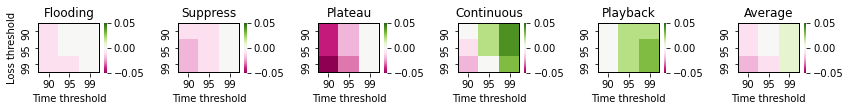

In [122]:
factor_df_clean = pd.DataFrame([])
fig, axs = plt.subplots(1,6, figsize = (12, 1.65))
for file_name, ax in zip(attack_names, axs.flatten()):
    roc_data[file_name]
    print(file_name)
    factor_df_clean = factor_df_final[factor_df_final['Attack'] == file_name]
    factor_df_clean_pivot = factor_df_clean.pivot(index='Loss th', columns='Time th', values='AUC Score')
#     print(factor_df_clean_pivot)
    print("Max AUC : ", factor_df_clean_pivot.max().max())
    print(f"Improvement: {(factor_df_clean_pivot.max().max() - roc_data[file_name]).values[0]}")

    X=factor_df_clean_pivot.columns.values
    Y=factor_df_clean_pivot.index.values
    Z=np.round((factor_df_clean_pivot - roc_data[file_name].values[0]),2)
    
    
    im = sns.heatmap(Z, ax = ax, cmap="PiYG", vmax = 0.05, vmin = -0.05)
    
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=factor_df_clean_pivot.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=factor_df_clean_pivot.shape[0], color='k',linewidth=2)


#     cbar = ax.collections[0].colorbar
#     cbar.set_ticks([-0.04, -0.02, 0.00, 0.02, 0.04])
#     cbar.set_ticklabels(["-0.04", "-0.02", "00.00", "+0.02", "+0.04"])
#     ax.plot([roc_data[file_name]] + Z.flatten().tolist(), marker = 'p')
#     x,y=np.meshgrid(X, Y)
#     cont = ax.contourf(x, y, Z)
#     cbar = plt.colorbar(cont, ax=ax)

    ax.set_xlabel('Time threshold')
#     ax.set_ylabel('Loss threshold') 
    
    if ax == axs[0]:
        ax.set_ylabel('Loss threshold') 
    else: 
        ax.set_ylabel(None)
    ax.set_title(file_name.capitalize())



# plt.grid(True)
plt.tight_layout()
# plt.savefig(f"plots//final//Threshold_Improvement_Signal_{dataset}.jpg", dpi = 350)
# plt.savefig(f"plots//final//Threshold_Improvement_Signal_{dataset}.pdf")
plt.show()

In [123]:
# # finalizing the thresholds graph..........
# ccmap = ['r', 'g', 'b']

# fig, axs = plt.subplots(1,1, figsize = (2.5, 2.5), sharey = False)
# for file_name, ax in zip(attack_names[-1:], [axs]):
    
#     sns.lineplot(palette= ccmap, ax = ax, alpha = 0.75, data = roc_df_clean[roc_df_clean['Selected']==1], y = file_name, markers=True, x = 'No of AE(s)', hue = 'Time Step', style = 'Time Step', markersize = '10')
    
    
#     ax.legend(framealpha = 0.75, ncol = 1,fontsize = '13')
#     ax.set_ylabel('AUC Score', fontsize = '13')
#     ax.set_xlabel('No of AE(s)',fontsize = '13')
#     ax.set_title(file_name.capitalize() ,fontsize = '13')
#     ax.grid(True)
# #     ax.set_xticks(fontsize = '13')

# plt.tight_layout()
# # plt.savefig(f"plots//final//Average_AUC_Scores_Final_{dataset}.jpg", dpi = 350)
# # plt.savefig(f"plots//final//Average_AUC_Scores_Final_{dataset}.pdf")
# plt.show()


continuous
Max AUC :  0.87045
Improvement: 0.04110999999999998
playback
Max AUC :  0.95202
Improvement: 0.031279999999999974


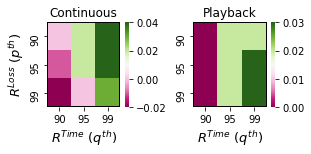

In [126]:
factor_df_clean = pd.DataFrame([])
fig, axs = plt.subplots(1,2, figsize = (4.5, 2.25))
for file_name, ax in zip(attack_names[3:5], axs.flatten()):
    roc_data[file_name]
    print(file_name)
    factor_df_clean = factor_df_final[factor_df_final['Attack'] == file_name]
    factor_df_clean_pivot = factor_df_clean.pivot(index='Loss th', columns='Time th', values='AUC Score')
#     print(factor_df_clean_pivot)
    print("Max AUC : ", factor_df_clean_pivot.max().max())
    print(f"Improvement: {(factor_df_clean_pivot.max().max() - roc_data[file_name]).values[0]}")

    X=factor_df_clean_pivot.columns.values
    Y=factor_df_clean_pivot.index.values
    Z=np.round((factor_df_clean_pivot - roc_data[file_name].values[0]),2)
    
    
    im = sns.heatmap(Z, ax = ax, cmap="PiYG") #, vmax = 0.03, vmin = -0.03)
    
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=factor_df_clean_pivot.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=factor_df_clean_pivot.shape[0], color='k',linewidth=2)


#     cbar = ax.collections[0].colorbar
#     cbar.set_ticks([-0.04, -0.02, 0.00, 0.02, 0.04])
#     cbar.set_ticklabels(["-0.04", "-0.02", "00.00", "+0.02", "+0.04"])
#     ax.plot([roc_data[file_name]] + Z.flatten().tolist(), marker = 'p')
#     x,y=np.meshgrid(X, Y)
#     cont = ax.contourf(x, y, Z)
#     cbar = plt.colorbar(cont, ax=ax)

#     ax.set_xlabel('Time threshold')
    ax.set_xlabel('${R^{Time}}$ ($q^{th}$)', fontsize = '13')
    

    #     ax.set_ylabel('Loss threshold') 
    
    if ax == axs[0]:
        #ax.set_ylabel('Loss threshold') 
        ax.set_ylabel('${R^{Loss}}$ ($p^{th}$)', fontsize = '13')
    else: 
        ax.set_ylabel(None)
    ax.set_title(file_name.capitalize())


# plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots//final//Threshold_Improvement_Signal_Final_{dataset}.jpg", dpi = 350)
plt.savefig(f"plots//final//Threshold_Improvement_Signal_Final_{dataset}.pdf")
plt.show()

In [127]:
loss_factors_opt = [95]
time_factors_opt = [99]

flooding
flooding_50_(1, 5, 10)_95_99
2565803
Except
2565803
2565803
0.9969274721822723
suppress
suppress_50_(1, 5, 10)_95_99
2102647
Except
2102647
2102647
0.9852375609007351
plateau
plateau_50_(1, 5, 10)_95_99
2140052
Except
2140052
2140052
0.9603316650802618
continuous
continuous_50_(1, 5, 10)_95_99
2140052
Except
2140052
2140052
0.8704530252721855
playback
playback_50_(1, 5, 10)_95_99
2140052
Except
2140052
2140052
0.948459850169566


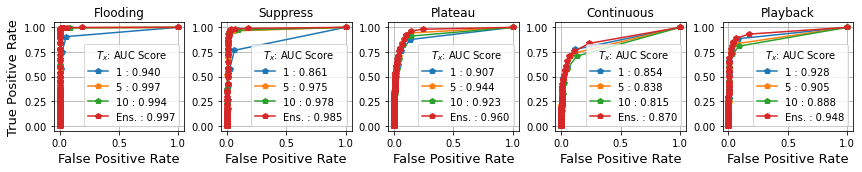

In [128]:
fig, axs = plt.subplots(1, 5, figsize = (12, 2.5)) #, sharey = True)
axes = axs.flatten()
colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']
#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for ax, file_name in zip(axs, attack_names):
    # Adding values...........
#     file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
       
    print(file_name)
    best_auc = 0
    for loss_factor_indx, loss_factor in enumerate(loss_factors_opt):
        for time_factor_indx, time_factor in enumerate(time_factors_opt):
            
            key = f"{file_name}_{time_step_opt}_{sampling_periods_opt}_{loss_factor}_{time_factor}"

            print(key)

            try: del y_pred_avg, y_test_avg 
            except: pass 

            for sampling_period_indx, sampling_period in enumerate(sampling_periods_opt):
                #--------------------------------------------------------------------------
                key_org = f"{file_name}_{time_step_opt}_{sampling_period}_{loss_factor}_{time_factor}"
                
                y_pred = y_sig_dict[key_org].copy() 
                y_test = y_true_dict[key_org].copy()
                print(len(y_pred))
                #--------------------------------------------------------------------------
                try:
                    y_pred_avg += np.array(y_pred)
                    y_test_avg += np.array(y_test)

                except:
                    y_pred_avg = np.array(y_pred)
                    y_test_avg = np.array(y_test)
                    print("Except")
                #--------------------------------------------------------------------------
                
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                label= "{0:01}".format(sampling_period) + ' : ' "{0:.3f}".format(roc_auc)

                ax.plot(fpr, tpr, label= label, marker = 'p')
                    
                
            y_pred_avg =y_pred_avg/len(sampling_periods_temp)
            y_test_avg =y_test_avg/len(sampling_periods_opt)
            y_test_avg = (y_test_avg>=0.5).astype(int)

            fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
            roc_auc = auc(fpr, tpr)
            
            print(roc_auc)
            ax.plot(fpr, tpr, label= "Ens. : {0:0.3f}".format(roc_auc), marker = 'p')
            ax.grid(True)
            ax.set_xlabel("False Positive Rate", fontsize = '13')
            
            if ax == axs[0]:
                ax.set_ylabel("True Positive Rate",fontsize = '13')
            else: 
                ax.set_ylabel(None)
            ax.set_title(file_name.capitalize())
    
            
            

    ax.set_title(f"{file_name.capitalize()}")
    ax.legend(title = "$T_x$: AUC Score")
    
plt.tight_layout()
plt.savefig(f"plots//final//ROC_Curve_Signal_{dataset}.jpg", dpi = 350)
plt.savefig(f"plots//final//ROC_Curve_Signal_{dataset}.pdf")
plt.show()  

In [129]:
t_mgs = 2

0 flooding
flooding_50_(1, 5, 10)_95_99
[[5822, 12093, 6271], [22985, 30175, 7190], [42157, 48212, 6055], [64426, 73009, 8583], [83176, 88730, 5554], [101286, 106312, 5026], [116300, 120377, 4077], [136796, 143395, 6599], [157703, 165956, 8253], [179611, 185063, 5452], [198576, 206558, 7982], [223384, 227694, 4310], [246824, 250910, 4086], [262365, 269471, 7106], [281311, 286938, 5627], [304006, 311263, 7257], [326970, 333510, 6540], [344239, 350845, 6606], [367130, 373773, 6643], [391740, 398524, 6784], [414503, 422326, 7823], [432985, 437786, 4801], [454774, 462626, 7852], [482289, 491742, 9453], [511497, 522714, 11217], [537189, 542858, 5669], [554525, 559503, 4978], [573143, 581123, 7980], [600406, 610852, 10446], [623585, 628749, 5164], [646943, 653112, 6169], [665242, 670744, 5502], [689673, 697855, 8182], [711488, 722373, 10885], [741058, 748048, 6990], [763103, 770847, 7744], [781805, 789125, 7320], [808888, 814361, 5473], [831666, 836006, 4340], [848000, 857456, 9456], [870178

[[5822, 12293, 6471], [22985, 30375, 7390], [42157, 48412, 6255], [64426, 73209, 8783], [83176, 88930, 5754], [101286, 106512, 5226], [116300, 120577, 4277], [136796, 143595, 6799], [157703, 166156, 8453], [179611, 185263, 5652], [198576, 206758, 8182], [223384, 227894, 4510], [246824, 251110, 4286], [262365, 269671, 7306], [281311, 287138, 5827], [304006, 311463, 7457], [326970, 333710, 6740], [344239, 351045, 6806], [367130, 373973, 6843], [391740, 398724, 6984], [414503, 422526, 8023], [432985, 437986, 5001], [454774, 462826, 8052], [482289, 491942, 9653], [511497, 522914, 11417], [537189, 543058, 5869], [554525, 559703, 5178], [573143, 581323, 8180], [600406, 611052, 10646], [623585, 628949, 5364], [646943, 653312, 6369], [665242, 670944, 5702], [689673, 698055, 8382], [711488, 722573, 11085], [741058, 748248, 7190], [763103, 771047, 7944], [781805, 789325, 7520], [808888, 814561, 5673], [831666, 836206, 4540], [848000, 857656, 9656], [870178, 875558, 5380], [888447, 894197, 5750],

[[9090, 12226, 3136], [24837, 27434, 2597], [42352, 45853, 3501], [64075, 67198, 3123], [78477, 82415, 3938], [93491, 97155, 3664], [109866, 113443, 3577], [132067, 134850, 2783], [148981, 152897, 3916], [169585, 172419, 2834], [185936, 189182, 3246], [198928, 202635, 3707], [221666, 225261, 3595], [243887, 247668, 3781], [262280, 265697, 3417], [276218, 278962, 2744], [290885, 293832, 2947], [303689, 306291, 2602], [316239, 318735, 2496], [329890, 333016, 3126], [346949, 349798, 2849], [363269, 366180, 2911], [378352, 381262, 2910], [393794, 397133, 3339], [410791, 414086, 3295], [424445, 427316, 2871], [444266, 447019, 2753], [462770, 466656, 3886], [477227, 480556, 3329], [496494, 499274, 2780], [515437, 518651, 3214], [530520, 534175, 3655], [553142, 555729, 2587], [570342, 573533, 3191], [584119, 588096, 3977], [603710, 607974, 4264], [621507, 624177, 2670], [639128, 643215, 4087], [652863, 657017, 4154], [670815, 675009, 4194], [692040, 694994, 2954], [705069, 708263, 3194], [722

[[9586, 12531, 2945], [31299, 33541, 2242], [51990, 54818, 2828], [68070, 70697, 2627], [89632, 93033, 3401], [110249, 114025, 3776], [133606, 137710, 4104], [153525, 156926, 3401], [167587, 169991, 2404], [187224, 190004, 2780], [200053, 204094, 4041], [222487, 224865, 2378], [239489, 243651, 4162], [261519, 265642, 4123], [283005, 285640, 2635], [296732, 299475, 2743], [314065, 316873, 2808], [327827, 331860, 4033], [348254, 352085, 3831], [370681, 373377, 2696], [391770, 394427, 2657], [410758, 414978, 4220], [427644, 431161, 3517], [442013, 444857, 2844], [460688, 464701, 4013], [482915, 486584, 3669], [500549, 504050, 3501], [516909, 520454, 3545], [532926, 536413, 3487], [553142, 556710, 3568], [568537, 571267, 2730], [589431, 592814, 3383], [608127, 610870, 2743], [629726, 633731, 4005], [645561, 648546, 2985], [661049, 664501, 3452], [679210, 681509, 2299], [699893, 703195, 3302], [717342, 720465, 3123], [737253, 740713, 3460], [755193, 759259, 4066], [773415, 776969, 3554], [7

[[13640, 16546, 2906], [29954, 33028, 3074], [48049, 50241, 2192], [83122, 86224, 3102], [103626, 106771, 3145], [118513, 121163, 2650], [135400, 138431, 3031], [156787, 159301, 2514], [174539, 178509, 3970], [197724, 201026, 3302], [219776, 223408, 3632], [234802, 237867, 3065], [248264, 251092, 2828], [274528, 277286, 2758], [292854, 296429, 3575], [325263, 328292, 3029], [346195, 349555, 3360], [365365, 367592, 2227], [379451, 382905, 3454], [397429, 401155, 3726], [414495, 417073, 2578], [431138, 433660, 2522], [449793, 453268, 3475], [468277, 472095, 3818], [486456, 490403, 3947], [504977, 508115, 3138], [535855, 537968, 2113], [566250, 568299, 2049], [580152, 582925, 2773], [613376, 617380, 4004], [628195, 630502, 2307], [663705, 666054, 2349], [700166, 702838, 2672], [720854, 724215, 3361], [735533, 738563, 3030], [755264, 757399, 2135], [773383, 776795, 3412], [790714, 794152, 3438], [807253, 810312, 3059], [826510, 828602, 2092], [847410, 851099, 3689], [906902, 910011, 3109],

[[14623, 16893, 2270], [36842, 39729, 2887], [95117, 97711, 2594], [109193, 112171, 2978], [131646, 135264, 3618], [147295, 149494, 2199], [175662, 179393, 3731], [195284, 198105, 2821], [216751, 220526, 3775], [233528, 235922, 2394], [252062, 256080, 4018], [267640, 270709, 3069], [286147, 288604, 2457], [305815, 309711, 3896], [323691, 326042, 2351], [376455, 380430, 3975], [398686, 400826, 2140], [417339, 421344, 4005], [453691, 457296, 3605], [476893, 480394, 3501], [492955, 495125, 2170], [551057, 554051, 2994], [565170, 568803, 3633], [586491, 590194, 3703], [600927, 604379, 3452], [616665, 619215, 2550], [634905, 637375, 2470], [684779, 688334, 3555], [707244, 709334, 2090], [722865, 726240, 3375], [761336, 764370, 3034], [801407, 804565, 3158], [819278, 822708, 3430], [834985, 838345, 3360], [848918, 851590, 2672], [869040, 872685, 3645], [888298, 890669, 2371], [903695, 906582, 2887], [946084, 949416, 3332], [961736, 965204, 3468], [981820, 985481, 3661], [1023583, 1026585, 30

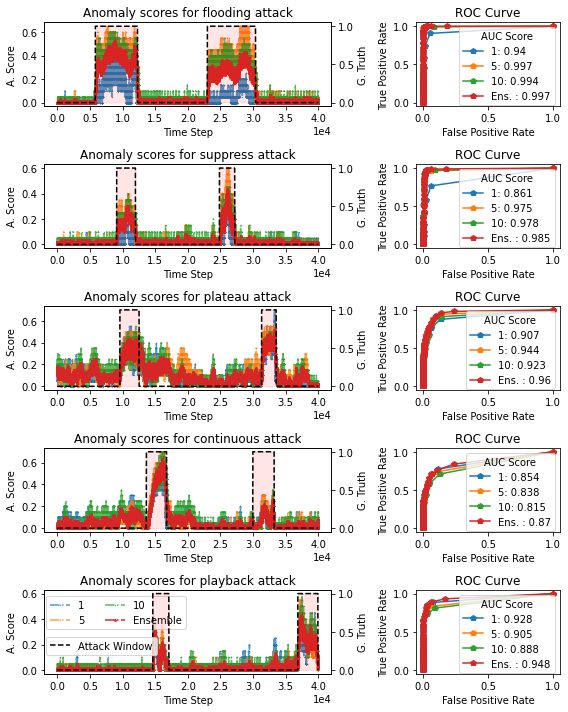

In [130]:
latency_df = []
event_df = []
fpr_list = [0.001, 0.005, 0.01]
#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
fig, axs = plt.subplots(5, 2, figsize = (8, 10), gridspec_kw={'width_ratios': [2, 1]})
for file_index,  file_name in enumerate(attack_names[:-1]):
    ax2 = axs[file_index, 0].twinx()
    print(file_index, file_name)

    best_auc = 0
    x = 0
    y = 40000 if dataset == 'syncan' else -1

    for loss_factor_indx, loss_factor in enumerate(loss_factors_opt):
        for time_factor_indx, time_factor in enumerate(time_factors_opt):
            
            key = f"{file_name}_{time_step_opt}_{sampling_periods_opt}_{loss_factor}_{time_factor}"

            print(key)

            try: del y_pred_avg, y_test_avg 
            except: pass 

            for sampling_period_indx, sampling_period in enumerate(sampling_periods_opt):
                #--------------------------------------------------------------------------
                key_org = f"{file_name}_{time_step_opt}_{sampling_period}_{loss_factor}_{time_factor}"
                
                y_pred = y_sig_dict[key_org].copy() 
                y_test = y_true_dict[key_org].copy()

                #--------------------------------------------------------------------------
                try:
                    y_pred_avg += np.array(y_pred)
                    y_test_avg += np.array(y_test)

                except:
                    y_pred_avg = np.array(y_pred)
                    y_test_avg = np.array(y_test)
                #--------------------------------------------------------------------------
                axs[file_index, 0].plot(y_pred[x:x+y], label=f"{sampling_period}", alpha = 0.75,  linestyle = '-.', marker = 'p', markersize = '0.5')

                
                fpr, tpr, ths = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)              
                axs[file_index, 1].plot(fpr, tpr, label=f"{sampling_period}: {round(roc_auc, 3)}", marker = 'p')

                # Determining delays........
                attacks, attack_index = find_attacks(y_test)
                #------------------------------
                print(attacks)
                for fpr_th in fpr_list:
                    th = ths[fpr > fpr_th][0]
                    tpr_opt = tpr[fpr <= fpr_th][-1]
                    y_pred_bin = (y_pred > th).astype(int).copy()
                    
                    #------------------------------------
                    for attack in attacks:
                        try:
                            delay = np.where(y_pred_bin[attack[0]:attack[1]] == 1)[0][0]
                        except:
                            delay = attack[2]
                        latency_df.append([file_name, str(sampling_period), fpr_th, tpr_opt, delay*t_mgs])
                    #------------------------------------
                
                    #-------- Defining event detection rate----
                    for detection_q in range(0,100,50):
                        attack_count = 0
                        for [attack_init, attack_end, attack_len]  in attacks:
                            if y_pred_bin[attack_init: attack_end].sum() >= attack_len*detection_q/100:
                                attack_count += 1
                        event_detection = attack_count/len(attacks)*100
                        event_df.append([file_name, sampling_period, fpr_th, detection_q, event_detection])
                    #------------------------------------

                

            y_pred_avg =y_pred_avg/len(sampling_periods_opt)
            y_test_avg =y_test_avg/len(sampling_periods_opt)
            y_test_avg_cut = y_test_avg.copy()
            y_test_avg = (y_test_avg >=0.50).astype(int)

                 
            ax2.plot(y_test_avg[x:x+y], label=f"Attack Window", color= 'k', linestyle = '--')#, marker = 'p')
            ax2.fill_between(range(y),y_test_avg[x:x+y], alpha = 0.1, color = 'r')
            axs[file_index, 0].plot(y_pred_avg[x:x+y], label=f"Ensemble", linestyle = '-.', marker = 'p', markersize = '2')
            axs[file_index, 0].set_xlabel("Time Step")
            axs[file_index, 0].set_ylabel("A. Score")
            ax2.set_ylabel("G. Truth")
#             axs[file_index, 0].set_title(f"Attack: {file_details[file_name]}")
            axs[file_index, 0].set_title(f"Anomaly scores for {file_name.lower()} attack")
            axs[file_index, 1].set_title(f"ROC Curve")

        
        
            fpr, tpr, ths = roc_curve(y_test_avg, y_pred_avg)
            roc_auc = auc(fpr, tpr)
            
            axs[file_index, 1].plot(fpr, tpr, label=f"Ens. : {round(roc_auc, 3)}", marker = 'p')
            axs[file_index, 1].set_xlabel("False Positive Rate")
            axs[file_index, 1].set_ylabel("True Positive Rate")
            axs[file_index, 1].legend(title = "AUC Score") #, loc = 'center right')
            
            # Determining delays........
            attacks, attack_index = find_attacks(y_test_avg)
            print(attacks)
            for fpr_th in fpr_list:
                th = ths[fpr >= fpr_th][0]
                tpr_opt = tpr[fpr <= fpr_th][-1]
                
                y_pred_avg_bin = (y_pred_avg > th).astype(int).copy()
  
              
                
                for attack in attacks:
                #------- Defining latency--------------
                    try:
                        delay = np.where(y_pred_avg_bin[attack[0]:attack[1]] == 1)[0][0]
                    except:
                        delay = attack[2]
                    
                    latency_df.append([file_name, "Ens.", fpr_th, tpr_opt, delay*t_mgs])
                #------------------------------------
                    
                #-------- Defining event detection rate----
                for detection_q in range(0,100,50):
                    attack_count = 0
                    for [attack_init, attack_end, attack_len]  in attacks:
                        if y_pred_avg_bin[attack_init: attack_end].sum() >= attack_len*detection_q/100:
                            attack_count += 1
                    event_detection = attack_count/len(attacks)*100
                    event_df.append([file_name, "Ens.", fpr_th, detection_q, event_detection])
                #------------------------------------

                if file_index == 4:
                    axs[file_index, 0].legend(ncol = 2, bbox_to_anchor=(0.25, 0.98), loc='upper center')
                    ax2.legend(bbox_to_anchor=(0.20, 0.50), loc='upper center') #, ncol = 4)
     
            #ax.legend()
#     ax.ticklabel_format(useOffset=False, style='sci')
    ax2.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    
plt.tight_layout()
plt.savefig(f"plots//final//attack_vis_w_roc_{dataset}.jpg", dpi = 450)
plt.savefig(f"plots//final//attack_vis_w_roc_{dataset}.pdf")

plt.show()  


In [ ]:
# file_details = {'max_speedometer': 'Max Speedometer',
# 'reverse_light_on': 'Reverse light on',
# 'reverse_light_off': 'Reverse light off',
# 'correlated_signal': 'Correlated Signals',
# 'max_engine_coolant_te': 'Max coolant temp'}
# file_details

In [131]:
latency_df = pd.DataFrame(latency_df)
latency_df.columns = ['Attack', 'Sampling Period(s)', 'Max FPR', 'True Positive Rate', 'Detection Latency']

latency_df_avg = latency_df.groupby(['Sampling Period(s)', 'Max FPR']).mean().copy()
latency_df_avg[['Attack','Sampling Period(s)', 'Max FPR']] = [["Average"] + list(x) for x in latency_df_avg.index]
latency_df_new = pd.concat([latency_df, latency_df_avg], ignore_index = True)
latency_df_new


,Attack,Sampling Period(s),Max FPR,True Positive Rate,Detection Latency
0,flooding,1,0.001,0.176006,12542.000000
1,flooding,1,0.001,0.176006,14380.000000
2,flooding,1,0.001,0.176006,12110.000000
3,flooding,1,0.001,0.176006,17166.000000
4,flooding,1,0.001,0.176006,11108.000000
...,...,...,...,...,...
6535,Average,5,0.005,0.553868,1316.823529
6536,Average,5,0.010,0.660498,977.242647
6537,Average,Ens.,0.001,0.219758,4443.191176
6538,Average,Ens.,0.005,0.494205,1889.996324


In [132]:
latency_df_avg = latency_df.groupby(['Sampling Period(s)', 'Max FPR']).mean().copy()
latency_df_avg[['Attack','Sampling Period(s)', 'Max FPR']] = [["Average"] + list(x) for x in latency_df_avg.index]
latency_df_new = pd.concat([latency_df, latency_df_avg], ignore_index = True)
latency_df_new


,Attack,Sampling Period(s),Max FPR,True Positive Rate,Detection Latency
0,flooding,1,0.001,0.176006,12542.000000
1,flooding,1,0.001,0.176006,14380.000000
2,flooding,1,0.001,0.176006,12110.000000
3,flooding,1,0.001,0.176006,17166.000000
4,flooding,1,0.001,0.176006,11108.000000
...,...,...,...,...,...
6535,Average,5,0.005,0.553868,1316.823529
6536,Average,5,0.010,0.660498,977.242647
6537,Average,Ens.,0.001,0.219758,4443.191176
6538,Average,Ens.,0.005,0.494205,1889.996324


In [133]:
latency_df_new['Detection Latency'] = latency_df_new['Detection Latency'] / 1000

In [134]:
latency_df_new

,Attack,Sampling Period(s),Max FPR,True Positive Rate,Detection Latency
0,flooding,1,0.001,0.176006,12.542000
1,flooding,1,0.001,0.176006,14.380000
2,flooding,1,0.001,0.176006,12.110000
3,flooding,1,0.001,0.176006,17.166000
4,flooding,1,0.001,0.176006,11.108000
...,...,...,...,...,...
6535,Average,5,0.005,0.553868,1.316824
6536,Average,5,0.010,0.660498,0.977243
6537,Average,Ens.,0.001,0.219758,4.443191
6538,Average,Ens.,0.005,0.494205,1.889996


In [138]:
latency_df_new['Sampling Period(s)']

0          1
1          1
2          1
3          1
4          1
        ... 
6535       5
6536       5
6537    Ens.
6538    Ens.
6539    Ens.
Name: Sampling Period(s), Length: 6540, dtype: object

In [135]:
# # plt.figure(figsize = (13, 3))


# sns.catplot(x="Max FPR", y="Detection Latency", hue='Sampling Period(s)',  col="Attack",
#                  data=latency_df, kind="bar",
#                 height= 2.35, aspect = .875, legend = False);
# plt.legend(loc = 'upper right', bbox_to_anchor = (1.05, 0.995))
# plt.tight_layout()
# plt.savefig(f"plots//final//Detection_Latency_{dataset}.jpg", dpi = 350)
# plt.savefig(f"plots//final//Detection_Latency_{dataset}.pdf")
# plt.show()

In [140]:
hue_order = ['1', '5', '10', 'Ens.']

flooding
suppress
plateau
continuous
playback
Average


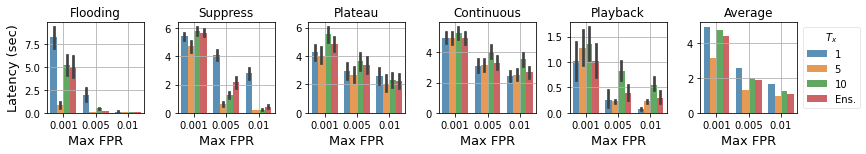

In [141]:
fig, axs = plt.subplots(1,6, figsize = (12,2.25))
for file_name, ax in zip(attack_names[0:], axs.flatten()):

    print(file_name)
    latency_df_clean = latency_df_new[latency_df_new['Attack'] == file_name]
    
    sns.barplot(data = latency_df_clean, alpha = .80, hue_order = hue_order, x="Max FPR", y="Detection Latency", hue='Sampling Period(s)', ax = ax)
    ax.set_title(file_name.capitalize())
    ax.grid(True)
    
    if ax == axs[0]:
        #ax.legend(title = '$T_x$', framealpha = 0.25, ncol = 1, loc = 'center', bbox_to_anchor = (0.75, 0.475))
#         ax.legend(title = '$T_x$', framealpha = 0.5, ncol = 1, loc = 'best') #, bbox_to_anchor = (0.75, 0.475))
        ax.set_ylabel('Latency (sec)', fontsize = '13')
    else:
#         ax.legend([])
        ax.set_ylabel(None)   
    
    if ax == axs[-1]:
        #ax.legend(title = '$T_x$', framealpha = 0.25, ncol = 1, loc = 'center', bbox_to_anchor = (0.75, 0.475))
        ax.legend(title = '$T_x$', framealpha = 0.45, ncol = 1, loc = 'center', bbox_to_anchor = (1.35, 0.50))
#         ax.set_ylabel('Latency (time step)', fontsize = '13')
    else:
        ax.legend('', frameon=False)
#         ax.set_ylabel(None) 
    
    
    ax.set_xlabel("Max FPR", fontsize = '13')
#     ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))

    
    
plt.tight_layout()
plt.savefig(f"plots//final//detection_latency_{dataset}.jpg", dpi = 450)
plt.savefig(f"plots//final//detection_latency_{dataset}.pdf")

plt.show()  


In [ ]:
event_df = pd.DataFrame(event_df)
event_df.columns = ['Attack', 'Sampling Period(s)', 'Max FPR', 'Q', 'Event Detection Rate']
event_df


In [ ]:
event_df_avg = event_df.groupby(['Sampling Period(s)', 'Max FPR', 'Q']).mean().copy()


In [ ]:
event_df_avg[['Attack','Sampling Period(s)', 'Max FPR', 'Q']] = [["Average"] + list(x) for x in event_df_avg.index]
event_df_new = pd.concat([event_df, event_df_avg], ignore_index = True)
event_df_new

In [ ]:
event_df_new = event_df_new[event_df_new['Max FPR'] == 0.01]

In [ ]:
fig, axs = plt.subplots(1,6, figsize = (12,2.4))
for file_name, ax in zip(attack_names[0:], axs.flatten()):

    print(file_name)
    event_df_clean = event_df_new[event_df_new['Attack'] == file_name].copy()
    sns.lineplot(data = event_df_clean, x = "Q", y = 'Event Detection Rate', hue 
                      = 'Sampling Period(s)', style  = 'Sampling Period(s)', markers=True, ax = ax, markersize= '10')
    ax.set_title(file_name.capitalize())
    ax.grid(True)
    
    if ax == axs[0]:
        #ax.legend(title = '$T_x$', framealpha = 0.25, ncol = 1, loc = 'center', bbox_to_anchor = (0.75, 0.475))
#         ax.legend(title = '$T_x$', framealpha = 0.5, ncol = 1, loc = 'best') #, bbox_to_anchor = (0.75, 0.475))
        ax.set_ylabel('Detected Events (%)', fontsize = '13')
    else:
#         ax.legend([], frameon=False)
        ax.set_ylabel(None)   
    
    if ax == axs[2]:
        #ax.legend(title = '$T_x$', framealpha = 0.25, ncol = 1, loc = 'center', bbox_to_anchor = (0.75, 0.475))
        ax.legend(title = '$T_x$', framealpha = 0.5, ncol = 1, loc= 'center', bbox_to_anchor = (0.325, 0.375))
#         ax.set_ylabel('Detected Events (%)', fontsize = '13')
    else:
        ax.legend([], frameon=False)
#         ax.set_ylabel(None)   
    
    
    ax.set_xlabel("Q(%)", fontsize = '13')
    
    
plt.tight_layout()
# plt.savefig(f"plots//final//event_detection_{dataset}.jpg", dpi = 450)
# plt.savefig(f"plots//final//event_detection_{dataset}.pdf")

plt.show()  

#   

In [143]:
# (0.997 + 0.985+  0.960 + 0.870 + 0.948)/5

0.952

In [144]:
# (0.979 + 0.882  +  0.983  + 0.936 + 0.974)/5

0.9507999999999999

In [ ]:
g = sns.catplot(x="Attack", y="Detection Latency", hue='Max FPR',  col="Sampling Period(s)",
                 data=latency_df, kind="boxen",
                height=4, aspect=.7);


In [ ]:
ax = plt.figure(figsize = (13, 3))


sns.catplot(x="Sampling Period(s)", y="Detection Latency",  col="Attack",
                 data=latency_df, kind="bar",
                height=2, aspect = .95, ax = ax);
plt.show()

In [ ]:
latency_df

In [ ]:


# In[386]:


g = sns.catplot(x="Sampling Period(s)", y="True Positive Rate", hue='Max FPR',  col="Attack",
                 data=latency_df,kind="bar",
                height=4, aspect=.7);


# In[387]:


In [ ]:


g = sns.catplot(x="Attack", y="Detection Latency", hue='Max FPR',  col="Sampling Period(s)",
                 data=latency_df, kind="violin",
                height=4, aspect=.7);


# In[388]:


In [ ]:


g = sns.catplot(x="Attack", y="True Positive Rate", hue='Max FPR',  col="Sampling Period(s)",
                 data=latency_df,kind="bar",
                height=4, aspect=.7);


# In[ ]:




In [ ]:



# In[389]:


g = sns.catplot(x="Sampling Period(s)", y="True Positive Rate", hue='Max FPR',  col="Attack",
                 data=latency_df, kind="bar",
                height=4, aspect=.7);



In [ ]:
factor_df_clean = pd.DataFrame([])
fig, axs = plt.subplots(1,5, figsize = (15,2.5))
for (file_name, file_index), ax in zip(file_indeces.items(), axs.flatten()):
    roc_data[file_name]
    print(file_name)
    factor_df_clean = factor_df[factor_df['Attack'] == file_name]
    factor_df_clean_pivot = factor_df_clean.pivot(index='Loss th', columns='Time th', values='AUC Score')
#     print(factor_df_clean_pivot)
    print("Max AUC : ", factor_df_clean_pivot.max().max())
    print(f"Improvement: {-roc_data[file_name]+factor_df_clean_pivot.max().max()}")
    

    X=factor_df_clean_pivot.columns.values
    Y=factor_df_clean_pivot.index.values
    Z=factor_df_clean_pivot.values
    x,y=np.meshgrid(X, Y)
    
    ax.plot([roc_data[file_name]] + Z.flatten().tolist(), marker = 'p')
#     sns.heatmap(factor_df_clean_pivot, vmax = 1.00, vmin = 0.5)


#     ax.contourf(x, y, Z)
#     plt.colorbar(ax)
    ax.set_title(file_name)

    
plt.grid(True)

#     plt.xlabel('x (cm)')
#     plt.ylabel('y (cm)')
#     plt.show()

# plt.contourf(x, y, Z, alpha=0.7, cmap=plt.cm.jet);
#     plt.show()

In [ ]:
# sampling_periods = [1 , 5, 10, 20] #, 50]
# loss_factors = [99]
# time_factors = [90]

In [ ]:
fig, axs = plt.subplots(1, 5, figsize = (15, 2.5))
axes = axs.flatten()
colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']

sampling_periods = [1, 5, 50]

#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for file_name, file_index in file_indeces.items():
    # Adding values...........
#     file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
       
    print(file_name)
    ax = axes[file_index]

    best_auc = 0
    for time_step_indx, time_step in enumerate(time_steps):
        y_pred_avg = 0
        for sampling_period_indx, sampling_period in enumerate(sampling_periods):
            for loss_factor_indx, loss_factor in enumerate(loss_factors):
                for time_factor_indx, time_factor in enumerate(time_factors):
                    key = f"{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                    y_pred = y_loss_dict[key].copy() 
                    y_test = y_true_dict[key].copy()
                    print(len(y_pred))
                    fpr, tpr, _ = roc_curve(y_test, y_pred)
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f"{time_step}_{sampling_period} : {round(roc_auc,2)}")
                    if best_auc < roc_auc:
                        best_auc = roc_auc
                        best_key = key
                    break
                break
            #------ Summing up...
            try:
                inshape = len(y_pred)
                exshape = y_pred_avg.shape[0]

                final_len = inshape if inshape < exshape else exshape
                #final_len = int (final_len/2)
                y_pred_avg[0:final_len] += np.array(y_pred)[0:final_len]
                y_test_avg[0:final_len] += np.array(y_test)[0:final_len]

            except:
                y_pred_avg = np.array(y_pred)
                y_test_avg = np.array(y_test)
                print("Except")
        sbest_key = best_key

        y_pred_avg =y_pred_avg/len(sampling_periods)
        y_test_avg =y_test_avg/len(sampling_periods)
        y_test_avg = (y_test_avg>0.5).astype(int)

        fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"Avg : {round(roc_auc,2)}")
        if best_auc < roc_auc:
            best_auc = roc_auc
            best_key = f"Combined"
    ax.set_title(f"Attack: {file_name}") #: AUC: {round(best_auc,2)} \n {best_key}")
    ax.legend(title = "AUC", loc = 'center right')
    ax.set_xlabel("False Positive")
    ax.set_ylabel("True Positive")
plt.tight_layout()
plt.savefig(f"plots//Overall//ROC_Loss_{dataset}.jpg", dpi = 350)
plt.show()  

In [ ]:
# sampling_periods = [1, 10, 50]


In [ ]:
# fig, axs = plt.subplots(1, 5, figsize = (15, 2.5))
# axes = axs.flatten()
# colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']

# #Loading datasets..................................
# for file_index, (file_name, ax) in enumerate(zip(testing_files, axes)):
#     print(file_name)
loss_factors = [99]
time_factors = [90]
sampling_periods = [1,  50]

fig, axs = plt.subplots(1, 5, figsize = (16, 3.5))
axes = axs.flatten()
colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']
#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for file_name, file_index in file_indeces.items():
    # Adding values...........
#     file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
       
    print(file_name)
    ax = axes[file_index]
    best_auc = 0
    for time_step_indx, time_step in enumerate(time_steps):
        y_pred_avg = 0
        for sampling_period_indx, sampling_period in enumerate(sampling_periods):
            for loss_factor_indx, loss_factor in enumerate(loss_factors):
                for time_factor_indx, time_factor in enumerate(time_factors):
                    key = f"{file_name}_{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
#                     print(key)
                    y_pred = y_time_dict[key].copy() 
                    y_test = y_true_dict[key].copy()
#                     print(len(y_pred))
                    fpr, tpr, _ = roc_curve(y_test, y_pred)
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f"{time_step}_{sampling_period} : {round(roc_auc,2)}", marker = 'p')
                    if best_auc < roc_auc:
                        best_auc = roc_auc
                        best_key = key
                    
            #------ Summing up...
            try:
                inshape = len(y_pred)
                exshape = y_pred_avg.shape[0]

                final_len = inshape if inshape < exshape else exshape

                y_pred_avg[0:final_len] += np.array(y_pred)[0:final_len]
                y_test_avg[0:final_len] += np.array(y_test)[0:final_len]

            except:
                y_pred_avg = np.array(y_pred)
                y_test_avg = np.array(y_test)
#                 print("Except")
        sbest_key = best_key

        y_pred_avg =y_pred_avg/sampling_period_indx 
        y_test_avg =y_test_avg/sampling_period_indx
        y_test_avg = (y_test_avg>0.5).astype(int)

        fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
        roc_auc = auc(fpr, tpr)
        
        if best_auc < roc_auc:
            best_auc = roc_auc
            best_key = f"Combined"
            
        ax.plot(fpr, tpr, label=f"Combined : {round(roc_auc,2)}", marker = 'p')
#         ax.plot(fpr, tpr, marker = 'p')

            
    ax.set_title(f"Attack: {file_name}: AUC: {round(best_auc,2)} \n {best_key}")
    ax.legend(title = "Time Step_Sampling: AUC")
plt.tight_layout()
plt.savefig(f"plots//Overall//ROC_Signal_{dataset}.jpg", dpi = 350)
plt.show()  

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (10, 8.5))
axes = axs.flatten()
colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']

#Loading datasets..................................
# for file_index, file_name in enumerate(testing_files):
for file_name, file_index in file_indeces.items():
    # Adding values...........
#     file_name = file_name[5:] if dataset == 'syncan' else file_name[:-20]
       
    print(file_name)
    ax = axes[file_index]
    ax2 =ax.twinx()
    x = -1000000
    sbest_key = f'{file_name}_50_1_99_90'
    
    y_pred = np.array(y_loss_dict[sbest_key]).copy() 
    y_test = np.array(y_true_dict[sbest_key]).copy()

    if file_index == 0:
        ax.plot(y_test[x:], label = "Ground Truth", color = 'g')
        ax2.plot(y_pred[x:], label = "Anomaly Score", color = 'r')
    else:
        ax.plot(y_test[x:],  color = 'g')
        ax2.plot(y_pred[x:], color = 'r')
    
    ax.set_title(f"Attack: {file_name}")
    ax.set_ylabel("G. Truth")
    ax2.set_ylabel("A. Score")
    ax.set_xlabel("Time step")
fig.legend( bbox_to_anchor=[0.15, 0.88], loc='center', ncol=1)
fig.suptitle("Visualization of attack detection on ROAD datasets")
plt.tight_layout()
plt.savefig(f"plots//Overall//Attacks_Vis_{dataset}.jpg", dpi = 350)
plt.show()  

In [ ]:

plt.figure()
best_auc = 0
for time_step_indx, time_step in enumerate(time_steps):
    y_pred_avg = 0
    for sampling_period_indx, sampling_period in enumerate(sampling_periods):
        for loss_factor_indx, loss_factor in enumerate(loss_factors):
            for time_factor_indx, time_factor in enumerate(time_factors):
                key = f"{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                y_pred = y_loss_dict[key].copy() 
                y_test = y_true_dict[key].copy()
                print(len(y_pred))
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{key} : {round(roc_auc,4)}", marker = 'p')
                if best_auc < roc_auc:
                    best_auc = roc_auc
                    best_key = key
                break
            break
        #------ Summing up...
        try:
            inshape = len(y_pred)
            exshape = y_pred_avg.shape[0]
            
            final_len = inshape if inshape < exshape else exshape
            
            y_pred_avg[0:final_len] += np.array(y_pred)[0:final_len]
            y_test_avg[0:final_len] += np.array(y_test)[0:final_len]

        except:
            y_pred_avg = np.array(y_pred)
            y_test_avg = np.array(y_test)
            print("Except")
    sbest_key = best_key
    
    y_pred_avg =y_pred_avg/sampling_period_indx 
    y_test_avg =y_test_avg/sampling_period_indx
    y_test_avg = (y_test_avg>0.5).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Combined : {round(roc_auc,4)}", marker = 'p')
    if best_auc < roc_auc:
        best_auc = roc_auc
        best_key = f"Combined"
                    
            
plt.legend()
plt.title(f"Best AUC: {best_auc} with {best_key}")
plt.show()       

In [ ]:
sbest_key

In [ ]:
# y_loss_dict.keys()

In [ ]:
plt.figure()
best_auc = 0

for time_step_indx, time_step in enumerate(time_steps):
    for sampling_period_indx, sampling_period in enumerate(sampling_periods):
        for loss_factor_indx, loss_factor in enumerate(loss_factors):
            for time_factor_indx, time_factor in enumerate(time_factors):
                key = f"{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                y_pred = y_time_dict[key].copy() 
                y_test = y_true_dict[key].copy()
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{key} : {round(roc_auc,4)}")
                if best_auc < roc_auc:
                    best_auc = roc_auc
                    best_key = key
                break

plt.legend()
plt.title(f"Best AUC: {best_auc} with {best_key}")
plt.show()

In [ ]:
y_pred = y_time_dict[best_key].copy() 
y_test = y_true_dict[best_key].copy()
plt.plot(y_test[0:])
plt.plot(y_pred[0:])
plt.title(best_key)

In [ ]:
plt.figure()
best_auc = 0
for time_step_indx, time_step in enumerate(time_steps):
    for sampling_period_indx, sampling_period in enumerate(sampling_periods):
        for loss_factor_indx, loss_factor in enumerate(loss_factors):
            for time_factor_indx, time_factor in enumerate(time_factors):
                key = f"{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                y_pred = y_sig_dict[key].copy() 
                y_test = y_true_dict[key].copy()
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{key} : {round(roc_auc,4)}")
#                 best_auc = roc_auc if best_auc < roc_auc else best_auc
                if best_auc < roc_auc:
                    best_auc = roc_auc
                    best_key = key
                
# plt.legend()
plt.title(f"Best AUC: {best_auc} with {best_key}")
plt.show()

In [ ]:
y_pred = y_sig_dict[best_key].copy() 
y_test = y_true_dict[best_key].copy()
plt.plot(y_test[0:])
plt.plot(y_pred[0:])
plt.title(best_key)

In [ ]:
sampling_periods = [1 , 5, 10]

In [ ]:
plt.figure()

best_auc = 0
for time_step_indx, time_step in enumerate(time_steps):
    y_pred_avg = 0
    for sampling_period_indx, sampling_period in enumerate(sampling_periods):
        for loss_factor_indx, loss_factor in enumerate(loss_factors):
            if loss_factor != 90:
                continue
            for time_factor_indx, time_factor in enumerate(time_factors):
                if time_factor != 99:
                    continue
                key = f"{time_step}_{sampling_period}_{loss_factor}_{time_factor}"
                
#                 print(key)
                
                y_pred = y_sig_dict[key].copy() 
                y_test = y_true_dict[key].copy()
                
                print(len(y_pred))
                fpr, tpr, _ = roc_curve(y_test, y_pred)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f"{key} : {round(roc_auc,4)}", marker = 'p')
                if best_auc < roc_auc:
                    best_auc = roc_auc
                    best_key = key
                
            
        #------ Summing up...
        try:
            inshape = len(y_pred)
            exshape = y_pred_avg.shape[0]
            
            final_len = inshape if inshape < exshape else exshape
            
            y_pred_avg[0:final_len] += np.array(y_pred)[0:final_len]
            y_test_avg[0:final_len] += np.array(y_test)[0:final_len]

        except:
            y_pred_avg = np.array(y_pred)
            y_test_avg = np.array(y_test)
            print("Except")
            
            
    y_pred_avg =y_pred_avg/sampling_period_indx 
#     y_test_avg =y_test_avg/sampling_period_indx
    y_test_avg = (y_test_avg>2).astype(int)
    
    fpr, tpr, _ = roc_curve(y_test_avg, y_pred_avg)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Combined : {round(roc_auc,4)}", marker = 'p')
    if best_auc < roc_auc:
        best_auc = roc_auc
        best_key = f"Combined"
                    
            
plt.legend()
plt.title(f"Best AUC: {best_auc} with {best_key}")
plt.show()       

In [ ]:
25_5_90_99

In [ ]:
# %%
#------- Initilizing models/loading model-------------
#-------- Transfering the model-------------------------------
    # Visualizing the attacks...............................    

y_pred_dict = {}
y_true_dict = {}
y_time_dict = {}


fig, ax2 = plt.subplots(figsize = (16, 4))
ax = ax2.twinx()
colors = ['b', 'r', 'g', 'c', 'k', 'b', 'y']

#Loading datasets..................................
# reading each dataset in a df file
index_init = 0
index_gray = 10000
for file_index, (file_name, data_dir) in enumerate(zip(testing_files, testing_dirs)):

    if file_name.split('_')[0] == 'accelerator':
        print("Acceleration Attack Skipping....")
        continue

    print("Loading dataset: ",file_name)
    file_dir = cur_dir + f"//..//data//generated//{file_name}_generated.csv"

    # Checking if the signalwise data already exists
    sig_df = pd.read_csv(file_dir, index_col = 0) 
    print(f"{file_name} onboarded!")

    # Defining the number of signals..............................
    num_of_train_samples = int(sig_df.shape[0]*training_samples)

    sig_df = sig_df.iloc[0:num_of_train_samples].copy()
    y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()


    if dataset == 'road':
        # Forward filling algorithm........
        sig_df = sig_df[signals_in_cluster].copy()

        print("Forward filling...")
        sig_df = sig_df.ffill().copy()
        sig_df = sig_df.bfill().dropna()   
        X_train = sig_df.values
        #--------------------------------
        print("X_train.shape", X_train.shape)

        scaler_train = get_minmax_scaler(signals_in_cluster)
        X_train = scaler_train.transform(X_train).copy()
        print("Done data treatment..")
        #------------------------------------
    else:
        print("No treatment needed for SynCAN!")


    index_end = index_init + X_train.shape[0]
    xrange = np.array(range(index_init, index_end))


    for time_step_indx, time_step in enumerate(time_steps):
        for sampling_period_indx, sampling_period in enumerate(sampling_periods):
            print("time_step: ", time_step, " sampling_period:", sampling_period)
            # Creating sequences...........................................
            print("Creating sequences....")
            x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period).copy()
            y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

            print("Training input shape: ", x_train_seq.shape)
 
            #.......................... Training the model ....................
            print("------------- Starting the training process----------------")
            checkpoint_path = f"AE_Models//autoendoer_canshield_{dataset}_{time_step}_{window_step}_{sampling_period}_{training_samples}.h5"

            try:
                autoencoder = load_model(checkpoint_path)
                print(f"Loaded...{checkpoint_path}")
            except:
                print("No model found!")

            print("------------------------ Done ------------------------")


            # Predicting
            #-------------  Training ------------------
            y_train_prob_org = calc_loss(x_train_seq[0::1], autoencoder)[:,:,:,0]   
            y_train_prob = y_train_prob_org.reshape(-1, noOfSignals)
            #-------------------------------------------
            y_train_prob_org_loss = np.mean(np.mean(y_train_prob_org, 2),1).copy()

            xrange = np.array(range(0, y_train_prob_org_loss.shape[0]*window_step, window_step))
            
            xrange += index_init


            if dataset == 'road':
                start = np.where(y_train_seq == 1)[0][0]
                end = np.where(y_train_seq == 1)[0][-1]
                y_train_seq_plot = (y_train_seq*0).copy()
                y_train_seq_plot[start:end:2] = 1
            except:
                y_train_seq_plot = y_train_seq.copy()


            #Adding the attack name in the plot                
            # Starting with time steps violations.............

            ths_image = []
            for signal in range(noOfSignals):
                ths_image.append(ths.loc[(time_step, sampling_period, factor, signal)]['th'])
            ths_image = np.array(ths_image)
            
            y_train_prob_org_bin = (y_train_prob_org> ths_image).astype(int).copy()
            y_train_prob_org_bin_count = np.sum(np.sum(y_train_prob_org_bin, 2),1)
            y_train_prob_org_bin_count = (y_train_prob_org_bin_count/(noOfSignals*time_step)).copy()
            
            # Adding values...........
            key = f"{time_step}_{sampling_period}"
            
            try:
                y_pred_dict[key] += list(y_train_prob_org_loss[0:len(xrange)])
                y_true_dict[key] += list(y_train_seq_plot[0:len(xrange)])
                y_time_dict[key] += list(y_train_prob_org_bin_count[0:len(xrange)])
            except:
                y_pred_dict[key] = list(y_train_prob_org_loss[0:len(xrange)])
                y_true_dict[key] = list(y_train_seq_plot[0:len(xrange)])
                y_time_dict[key] = list(y_train_prob_org_bin_count[0:len(xrange)])
            
            
            if file_index == 0:
                ax.plot(xrange, y_train_prob_org_bin_count[0:len(xrange)], color = colors[time_step_indx+sampling_period_indx], linestyle = '-', label = f'TS_{time_step}_{sampling_period}', alpha = 0.85)
            else:
                ax.plot(xrange, y_train_prob_org_bin_count[0:len(xrange)], color = colors[time_step_indx+sampling_period_indx], linestyle = '-', alpha = 0.85)


    
    index_init = index_end + index_gray
    
ax.legend(loc = 'upper right')            
plt.grid(True)
plt.tight_layout()
plt.savefig(f"plots//Overall//Attack_detect_all.jpg", dpi = 350)
plt.show()
#.............................

In [ ]:


        #             """
        #             # Visualizing the training performance...........
        #             print("------------- Showing reconstruction example -----------")
        #             try:
        #                 att_indx = np.where(y_train_seq == 1)[0][0]
        #             except:
        #                 att_indx = int(y_train_seq.shape[0]/2)

        #             #------- Ploting the data -------------------
        #             fig, axes = plt.subplots(3, 3, figsize = (12, 6))

        #             for indx, delay in enumerate([-5, 1, 5]):

        #                 plot_indx = att_indx + delay
        #                 input_image = x_train_seq[plot_indx:plot_indx+1].copy()
        #                 output_image = autoencoder.predict(input_image)
        #                 recon_loss = np.abs(output_image - input_image)

        #                 sns.heatmap(input_image[0,:,:,0], ax = axes [indx, 0], vmin = 0, vmax = 1)
        #                 axes[indx, 0].set_title("input_image")
        #                 sns.heatmap(output_image[0,:,:,0], ax = axes[indx, 1], vmin = 0, vmax = 1)
        #                 axes[indx, 1].set_title("output_image")
        #                 sns.heatmap(recon_loss[0,:,:,0], ax = axes[indx, 2], vmin = 0, vmax = 1)
        #                 axes[indx, 2].set_title("recon_loss")
        #                 axes[indx, 1].set_title(f"After {delay} steps of attack")

        #             fig.suptitle(f"Attack: {file_name}")
        #             plt.tight_layout()
        #             plt.show()
        #             #-----------------------------------------------------
        #             #-----------------------------------------------------
        #             print("....... Done.......")
        #             #-----------------------------------------------------
        #             """

In [ ]:
# # %%
# #------- Initilizing models/loading model-------------
# #-------- Transfering the model-------------------------------
#             # Visualizing the attacks...............................    
# for time_step in time_steps:
#     for sampling_period in sampling_periods:
#         print("time_step: ", time_step, " sampling_period:", sampling_period)

#         fig, ax2 = plt.subplots(figsize = (16, 4))
#         ax = ax2.twinx()
#         colors = ['b', 'g', 'y', 'c', 'k', 'b', 'g']

#         #Loading datasets..................................
#         # reading each dataset in a df file
#         index_init = 0
#         index_gray = 10000
#         for file_index, (file_name, data_dir) in enumerate(zip(testing_files, testing_dirs)):

#             if file_name.split('_')[0] == 'accelerator':
#                 print("Acceleration Attack Skipping....")
#                 continue
            
#             print("Loading dataset: ",file_name)
#             file_dir = cur_dir + f"//..//data//generated//{file_name}_generated.csv"

#             # Checking if the signalwise data already exists
#             sig_df = pd.read_csv(file_dir, index_col = 0) 
#             print(f"{file_name} onboarded!")

#             # Defining the number of signals..............................
#             num_of_train_samples = int(sig_df.shape[0]*training_samples)
                    
#             sig_df = sig_df.iloc[0:num_of_train_samples].copy()
#             y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()

            
#             if data_source == 'road':
#                 # Forward filling algorithm........
#                 sig_df = sig_df[signals_in_cluster].copy()

#                 print("Forward filling...")
#                 sig_df = sig_df.ffill().copy()
#                 sig_df = sig_df.bfill().dropna()   
#                 X_train = sig_df.values
#                 #--------------------------------
#                 print("X_train.shape", X_train.shape)

#                 scaler_train = get_minmax_scaler(signals_in_cluster)
#                 X_train = scaler_train.transform(X_train).copy()
#                 print("Done data treatment..")
#                 #------------------------------------
#             else:
#                 print("No treatment needed for SynCAN!")

#             # Creating sequences...........................................
#             print("Creating sequences....")
#             x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period).copy()
#             y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

#             print("Training input shape: ", x_train_seq.shape)
#             #-----------------------------------------------------------
            
# #             plt.figure()
# #             sns.heatmap(x_train_seq[100,:,:,0])
# #             plt.title(f"{sampling_period}_{file_name}")
# #             plt.show()
# #             #-----------------------------------------------------------

#             #----------------  Starting the training--------------------

#             print(f"Training model in {file_name} with sampling freq: {sampling_period}")


#             #.......................... Training the model ....................
#             print("------------- Starting the training process----------------")
#             checkpoint_path = f"AE_Models//autoendoer_canshield_{data_source}_{time_step}_{window_step}_{sampling_period}_{training_samples}.h5"

#             try:
#                 autoencoder = load_model(checkpoint_path)
#                 print(f"Loaded...{checkpoint_path}")
#             except:
#                 print("No model found!")
            
#             print("------------------------ Done ------------------------")

            
#             # Predicting
#             #-------------  Training ------------------
#             y_train_prob_org = calc_loss(x_train_seq[0::1], autoencoder)[:,:,:,0]   
#             y_train_prob = y_train_prob_org.reshape(-1,noOfSignals)
#             #-------------------------------------------
#             y_train_prob_org_loss = np.mean(np.mean(y_train_prob_org, 2),1).copy()
        
        
#             # Visualizing the attacks...............................    
# #             fig, ax2 = plt.subplots(figsize = (6, 4))
# #             colors = ['b', 'g', 'y', 'c', 'k', 'b', 'g']
#             try:
#                 att_signals = attacked_signals[file_name]
#             except:
#                 att_signals = targeted_signals.copy()

#             att_signals = targeted_signals.copy()
#             index_end = index_init + X_train.shape[0]
#             xrange = np.array(range(index_init, index_end))
            

#             print(xrange[0], xrange[-1], xrange.shape, X_train[:, col].shape)
            
#             for color, att_sig in zip(colors, att_signals):
#                 col = signals_in_cluster.index(att_sig)
#                 ax2.plot(xrange, X_train[:, col], label = att_sig, color = color)
#             ax2.set_xlabel("Time Step")
#             ax2.set_ylabel("Signal value")
            
#             #Adding second y ticks
# #             ax = ax2.twinx()
           
#             xrange = np.array(range(0, y_train_prob_org_loss.shape[0]*window_step, window_step))
#             xrange += index_init
#             print(xrange[0], xrange[-1], xrange.shape, X_train[:, col].shape)

#             ax.plot(xrange, y_train_prob_org_loss[0:len(xrange)], linestyle = '--', label = 'Anoamly Score', color = 'r', alpha = 0.85)
#             ax.set_ylabel("Anomaly Score")
            
#             gray_data = np.zeros((index_gray), dtype = int)
#             gray_data[0::2] = 1
#             ax2.plot(range(index_end,index_end+index_gray),gray_data, color = 'grey')

#             #ax.set_ylabel("Mean Absolute Loss")
#             # ax.legend(loc = 'best')
#             # ax.grid(True)
#             #---------------------------------


#             # ax.legend(loc = 'best')
#             # ax2.legend(loc = 'best')
#             try:
#                 start = np.where(y_train_seq == 1)[0][0]
#                 end = np.where(y_train_seq == 1)[0][-1]
#                 y_train_seq_plot = (y_train_seq*0).copy()
#                 y_train_seq_plot[start:end:2] = 1
#             except:
#                 y_train_seq_plot = y_train_seq

#             ax2.plot(xrange, y_train_seq_plot[0:len(xrange)], label = 'Attacked Region', alpha = 0.15, color = 'y')
            
#             #Adding the attack name in the plot
#             ax2.text(0, (9-file_index)/10, f'{file_index}: {file_name}')
            
#             index_init = index_end + index_gray
            
# #       ax.figure.legend(loc = 'upper left')
# #         plt.title(f"Attack: {file_name}")
#         plt.grid(True)
#         plt.tight_layout()
#         plt.savefig(f"plots//Overall//Attack_detect_all.jpg", dpi = 350)
#         plt.show()
#         #.............................


        
# #             """
# #             # Visualizing the training performance...........
# #             print("------------- Showing reconstruction example -----------")
# #             try:
# #                 att_indx = np.where(y_train_seq == 1)[0][0]
# #             except:
# #                 att_indx = int(y_train_seq.shape[0]/2)
            
# #             #------- Ploting the data -------------------
# #             fig, axes = plt.subplots(3, 3, figsize = (12, 6))
            
# #             for indx, delay in enumerate([-5, 1, 5]):
                
# #                 plot_indx = att_indx + delay
# #                 input_image = x_train_seq[plot_indx:plot_indx+1].copy()
# #                 output_image = autoencoder.predict(input_image)
# #                 recon_loss = np.abs(output_image - input_image)

# #                 sns.heatmap(input_image[0,:,:,0], ax = axes [indx, 0], vmin = 0, vmax = 1)
# #                 axes[indx, 0].set_title("input_image")
# #                 sns.heatmap(output_image[0,:,:,0], ax = axes[indx, 1], vmin = 0, vmax = 1)
# #                 axes[indx, 1].set_title("output_image")
# #                 sns.heatmap(recon_loss[0,:,:,0], ax = axes[indx, 2], vmin = 0, vmax = 1)
# #                 axes[indx, 2].set_title("recon_loss")
# #                 axes[indx, 1].set_title(f"After {delay} steps of attack")
                
# #             fig.suptitle(f"Attack: {file_name}")
# #             plt.tight_layout()
# #             plt.show()
# #             #-----------------------------------------------------
# #             #-----------------------------------------------------
# #             print("....... Done.......")
# #             #-----------------------------------------------------
# #             """

In [ ]:
# # %%
# #------- Initilizing models/loading model-------------
# #-------- Transfering the model-------------------------------
# for time_step in time_steps:
#     for sampling_period in sampling_periods:
#         print("time_step: ", time_step, " sampling_period:", sampling_period)

#         #Loading datasets..................................
#         # reading each dataset in a df file
#         for file_name, data_dir in zip(testing_files, testing_dirs):

#             if file_name.split('_')[0] == 'accelerator':
#                 print("Acceleration Attack Skipping....")
#                 continue
            
#             print("Loading dataset: ",file_name)
#             file_dir = cur_dir + f"//..//data//generated//{file_name}_generated.csv"

#             # Checking if the signalwise data already exists
#             sig_df = pd.read_csv(file_dir, index_col = 0) 
#             print(f"{file_name} onboarded!")

#             # Defining the number of signals..............................
#             num_of_train_samples = int(sig_df.shape[0]*training_samples)
                    
#             sig_df = sig_df.iloc[0:num_of_train_samples].copy()
#             y_train = sig_df['Label'].iloc[0:num_of_train_samples].copy()

            
#             if data_source == 'road':
#                 # Forward filling algorithm........
#                 sig_df = sig_df[signals_in_cluster].copy()

#                 print("Forward filling...")
#                 sig_df = sig_df.ffill().copy()
#                 sig_df = sig_df.bfill().dropna()   
#                 X_train = sig_df.values
#                 #--------------------------------
#                 print("X_train.shape", X_train.shape)

#                 scaler_train = get_minmax_scaler(signals_in_cluster)
#                 X_train = scaler_train.transform(X_train).copy()
#                 print("Done data treatment..")
#                 #------------------------------------
#             else:
#                 print("No treatment needed for SynCAN!")

#             # Creating sequences...........................................
#             print("Creating sequences....")
#             x_train_seq = create_x_sequences(X_train, time_step, window_step, sampling_period).copy()
#             y_train_seq = create_y_sequences(y_train, time_step, window_step, sampling_period).copy()

#             print("Training input shape: ", x_train_seq.shape)
#             #-----------------------------------------------------------
            
#             plt.figure()
#             sns.heatmap(x_train_seq[100,:,:,0])
#             plt.title(f"{sampling_period}_{file_name}")
#             plt.show()
#             #-----------------------------------------------------------

#             #----------------  Starting the training--------------------

#             print(f"Training model in {file_name} with sampling freq: {sampling_period}")


#             #.......................... Training the model ....................
#             print("------------- Starting the training process----------------")
#             checkpoint_path = f"AE_Models//autoendoer_canshield_{data_source}_{time_step}_{window_step}_{sampling_period}_{training_samples}.h5"

#             try:
#                 autoencoder = load_model(checkpoint_path)
#                 print(f"Loaded...{checkpoint_path}")
#             except:
#                 print("No model found!")
            
#             print("------------------------ Done ------------------------")

            
#             # Predicting
#             #-------------  Training ------------------
#             y_train_prob_org = calc_loss(x_train_seq[0::1], autoencoder)[:,:,:,0]   
#             y_train_prob = y_train_prob_org.reshape(-1,noOfSignals)
#             #-------------------------------------------
#             y_train_prob_org_loss = np.mean(np.mean(y_train_prob_org, 2),1).copy()
        
        
#             # Visualizing the attacks...............................    
#             fig, ax2 = plt.subplots(figsize = (6, 4))
#             colors = ['b', 'g', 'y', 'c', 'k', 'b', 'g']
#             try:
#                 att_signals = attacked_signals[file_name]
#             except:
#                 att_signals = targeted_signals.copy()

#             for color, att_sig in zip(colors, att_signals):
#                 col = signals_in_cluster.index(att_sig)
#                 ax2.plot((X_train[:, col]), label = att_sig, color = color)
#             ax2.set_xlabel("Time Step")
#             ax2.set_ylabel("Signal value")
            
#             #Adding second y ticks
#             ax = ax2.twinx()
#             temp_x = list(range(0, y_train_prob_org_loss.shape[0]*window_step, window_step))
#             ax.plot(temp_x, y_train_prob_org_loss[0:len(temp_x)], linestyle = '--', label = 'Anoamly Score', color = 'r', alpha = 0.70)
#             ax.set_ylabel("Anomaly Score")
#             #ax.set_ylabel("Mean Absolute Loss")
#             # ax.legend(loc = 'best')
#             # ax.grid(True)
#             #---------------------------------


#             # ax.legend(loc = 'best')
#             # ax2.legend(loc = 'best')
#             try:
#                 start = np.where(y_train_seq == 1)[0][0]
#                 end = np.where(y_train_seq == 1)[0][-1]
#                 y_train_seq_plot = (y_train_seq*0).copy()
#                 y_train_seq_plot[start:end:2] = 1
#             except:
#                 y_train_seq_plot = y_train_seq

#             ax2.plot(temp_x, y_train_seq_plot[0:len(temp_x)], label = 'Attacked Region', alpha = 0.15, color = 'y')
#             ax.figure.legend(loc = 'upper left')
#             plt.title(f"Attack: {file_name}")
#             plt.grid(True)
#             plt.tight_layout()
# #             plt.savefig(f"plots//Attack_detect_{file_name}.jpg", dpi = 350)
#             plt.show()
#             #.............................


        
#             """
#             # Visualizing the training performance...........
#             print("------------- Showing reconstruction example -----------")
#             try:
#                 att_indx = np.where(y_train_seq == 1)[0][0]
#             except:
#                 att_indx = int(y_train_seq.shape[0]/2)
            
#             #------- Ploting the data -------------------
#             fig, axes = plt.subplots(3, 3, figsize = (12, 6))
            
#             for indx, delay in enumerate([-5, 1, 5]):
                
#                 plot_indx = att_indx + delay
#                 input_image = x_train_seq[plot_indx:plot_indx+1].copy()
#                 output_image = autoencoder.predict(input_image)
#                 recon_loss = np.abs(output_image - input_image)

#                 sns.heatmap(input_image[0,:,:,0], ax = axes [indx, 0], vmin = 0, vmax = 1)
#                 axes[indx, 0].set_title("input_image")
#                 sns.heatmap(output_image[0,:,:,0], ax = axes[indx, 1], vmin = 0, vmax = 1)
#                 axes[indx, 1].set_title("output_image")
#                 sns.heatmap(recon_loss[0,:,:,0], ax = axes[indx, 2], vmin = 0, vmax = 1)
#                 axes[indx, 2].set_title("recon_loss")
#                 axes[indx, 1].set_title(f"After {delay} steps of attack")
                
#             fig.suptitle(f"Attack: {file_name}")
#             plt.tight_layout()
#             plt.show()
#             #-----------------------------------------------------
#             #-----------------------------------------------------
#             print("....... Done.......")
#             #-----------------------------------------------------
#             """